# 1. Datapreprocessing

In this part I do the following tasks.
1. Load the data from mongo DB and sum up characteristics for fields
2. Convert to pandas dataframe
3. Check for missing values
4. Remove duplicates
5. Describe Dataset and look for outliers
6. Final view on cleaned dataset

## 1.1 Load the data from mongo db and sum up characteristics for fields

In [188]:
import json
from pymongo import MongoClient
import pymongo
import random
import pandas as pd

client = MongoClient('localhost', 27017)

# let's get the list of DBs already defined
print(client.list_database_names())

ServerSelectionTimeoutError: localhost:27017: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte, Timeout: 30s, Topology Description: <TopologyDescription id: 659730add7470ef7559187da, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte')>]>

In [ ]:
# first get the collection where we stored the posts
posts = client["bda"]["posts"]

In [ ]:
# look at length
client['bda']['posts'].count_documents({})

709031

I used the instagram graph api end point for recent media https://developers.facebook.com/docs/instagram-api/reference/ig-hashtag/recent-media.In following there can be seen the fields I can get with it and the _id field which was was is created by mongo db.

Later we look also on the distribution of the values, but I want give here a short description summing up the details I find in the instagram graph api.

We have in total 9 fields for one document(post) in our mongodb database:
- _id: Mongo db automatically created unique id for each document, which represents a post in our case. The first 4 bytes of the ids represent the seconds since the unix epoch.
- id: the id the post has in instagram. Every instagram post has a unique id.
- caption: includes the caption of the post, captions can not be hidden when creating a post. Captions can be maximum 2200 characters and contain a maximum of 30 hashtags. Also for retured      captions the @ is deleted, which is used for linking instagram pages or accounts.
- like_count: the like_count consists of the likes for posts, which includes also the likes for comments in that post.
- comments_count: the count of comments for the post, including also replie comments for comments. 
- permalink: Permanent URL to the post.
- timestamp: format is year-month-day hours:minutes:seconds. The timestamp is in UTC-00, which is the timezone of London (England), in Spain we are one hour latter (UTC + 1).
- media type: Media type. Can be CAROUSEL_ALBUM, IMAGE, or VIDEO. CAROUSEL_ALBUM is a collection of Videos and images, that the post contains.
- media_url: The URL for the media, that means only the image or video is shown regarding to that post. In case of when we have a CAROUSEL_ALBUM or on the media has a copyright or a copyright violation than the media url field is not returned.

Since I will not analyse the images and videos a post a contains, so the media the post contains. I decided to grab all fields except the children field, which is only returned for CAROUSEL_ALBUM posts, it returnes the ids for the videos and images the post contains. Consequently I will delete also latter the media url field. It has to be highlighted that when a post get's a like or a comment this comment or like is for the post and not for a specific image or video in that post, leading that the childrens of a CAROUSEL_ALBUM post, not supply any further information to the like or comment count.

The most important field for my analysis is the caption field which contains the hashtag. We will use it for language and sentiment analysis.

The like count and comments count fields are strong indicators for the popularity and the engagement of the instagram users of posts. Nevertheless because we grabbed the posts on different time points. For example one post can be grabbed two minutes after it appeared whereas an nother post is grabed 20 hours after it appeared. Nevertheless we think we can use the like and comment count to see a part of posts that gained a lot of comments and likes.

The timestamp is usefull for our analysis, especially we can see how much posts we grabbed on each day. The media type could be also used in analysis. The permalink is also usefull, when we want to see the regarding posts on instagram.



In [ ]:
# look at the first data row
posts.find_one()


{'_id': ObjectId('658b057ab5aa05caea7c43b0'),
 'caption': 'Seorang gadis terjebak di bawah reruntuhan rumah yang hancur di Jalur Gaza. Melalui m.z.gaza\n\n #freepalestine #freepalestine🇵🇸❤️ #palestine #fyp #gaza #gazatonight #islam #kemanusiaan #pbb #peace #stopwar #joebiden #putin #kingsalman #world #stopthewar #stopgenocide #stopgenocideingaza #unicef #indonesia #savechild #savechildrenpalestine #russia #turkey #urope #humanity #lfl #dubai #america',
 'like_count': 0,
 'permalink': 'https://www.instagram.com/reel/C1UorsTvhDd/',
 'timestamp': '2023-12-26T16:10:40+0000',
 'media_type': 'VIDEO',
 'comments_count': 0,
 'media_url': 'https://scontent-fra5-1.cdninstagram.com/o1/v/t16/f1/m82/E649213474C7BEF1B3F451571D498FB5_video_dashinit.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLmNsaXBzLnVua25vd24tQzMuNzIwLmRhc2hfYmFzZWxpbmVfMV92MSJ9&_nc_ht=scontent-fra5-1.cdninstagram.com&_nc_cat=106&vs=892790979215296_405417794&_nc_vs=HBksFQIYT2lnX3hwdl9yZWVsc19wZXJtYW5lbnRfcHJvZC9FNjQ5MjEzNDc0Qzd

In [ ]:
# all documents have an id

print(f"mising id: {posts.count_documents({'id':None})}")
print(f"mising caption: {posts.count_documents({'caption':None})}")
print(f"timestamp: {posts.count_documents({'timestamp':None})}")
print(f"permalink: {posts.count_documents({'permalink':None})}")
print(f"media_type: {posts.count_documents({'media_type':None})}")
print(f"permalink: {posts.count_documents({'timestamp':None})}")
print(f"comments_count: {posts.count_documents({'comments_count':None})}")
print(f"like_count: {posts.count_documents({'like_count':None})}")
print(f"media_url: {posts.count_documents({'media_url':None})}")


mising id: 0
mising caption: 1894
timestamp: 0
permalink: 0
media_type: 0
permalink: 0
comments_count: 0
like_count: 45631
media_url: 150277


In [ ]:
# we have missing values for the caption, the like_count and media_url, maybe because on the post was no caption given
res = posts.find({'caption':None}).limit(5)

In [ ]:
for x in res:
    print(x)

{'_id': ObjectId('658b057ab5aa05caea7c442c'), 'like_count': 0, 'permalink': 'https://www.instagram.com/p/C1Uny-tt9Zg/', 'timestamp': '2023-12-26T16:01:55+0000', 'media_type': 'IMAGE', 'comments_count': 1, 'media_url': 'https://scontent-fra3-1.cdninstagram.com/v/t51.29350-15/413411290_1549984449135550_3746586333223642152_n.jpg?_nc_cat=105&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=99q2auIFE1YAX-5Tuxe&_nc_ht=scontent-fra3-1.cdninstagram.com&edm=AEoDcc0EAAAA&oh=00_AfCtv3d5-2pk5Sy03C5dWTbmX6mTfKm10Znkap-E7so4Tg&oe=658FEA04', 'id': '18012334579924947'}
{'_id': ObjectId('658b057ab5aa05caea7c44b7'), 'like_count': 14, 'permalink': 'https://www.instagram.com/p/C1UnDGLosfF/', 'timestamp': '2023-12-26T15:55:23+0000', 'media_type': 'IMAGE', 'comments_count': 2, 'media_url': 'https://scontent-fra5-1.cdninstagram.com/v/t51.29350-15/412561241_1034231524514270_696652521627520476_n.heic?stp=dst-jpg&_nc_cat=100&ccb=1-7&_nc_sid=c4dd86&_nc_ohc=JAH5QzuY4AUAX_oMGj3&_nc_oc=AQnNuAcOAFd5Inqd06TJLw72Zznra21nz0OWP2dR3mtTDH8

So we see that the field cpation is missing in those. This is really suspicious because we should get only posts where hashtags are. When into for example the first one listed and click on it's permalink https://www.instagram.com/p/C1Uny-tt9Zg/ . I  can see that it has really no caption. I think this is because of an error in the instagram graph api. Anyway because my analysis is hastag based I will remove samples with missing captions. The like count and media url is not important for us, so we will keep samples with null values there. Nevertheless let's take also a look for missing media url and like count.

In [ ]:
# first look at the missing values for media url 
res = posts.find({'media_url':None}).limit(5)

In [ ]:
for x in res:
    print(x)

{'_id': ObjectId('658b057ab5aa05caea7c43b5'), 'caption': 'Day 81\n\nStrawberry  fields forever.\n\n#warstories\n#israel\n#gaza \n#childrenofwar', 'like_count': 0, 'permalink': 'https://www.instagram.com/reel/C1UonAftrX5/', 'timestamp': '2023-12-26T16:10:22+0000', 'media_type': 'VIDEO', 'comments_count': 0, 'id': '18251065054209917'}
{'_id': ObjectId('658b057ab5aa05caea7c43be'), 'caption': 'Palestinian families displaced from areas in the sector fleeing Israeli bombings, the land and streets have been flooded due to lack of space in schools and shelter centers in Gaza. \n #CeasefireNOW \n-\nPost by rabie_noqaira \n-\n#FreePalestine #palestinian #gaza #jerusalem #تصويري #photographer  #palestine #alaqsa #Occupation #Blockade \n#SaveSheikhJarrah #SavePalestine #GazaUnderAttack #gazastrip  #muslim #indonesia #pakistan #qatar  #Malaysia  #filistin #team_palestina #endisraeliapartheid #holdisraelaccountable \u202c\u2069 \u2067\u202b#غزة_الآن\u202c\u2069 \u2067\u202b#غزة\u202c\u2069 \u2067\u2

In [ ]:
# look at the missing values for like count
res = posts.find({'like_count':None}).limit(5)
for x in res:
    print(x)


{'_id': ObjectId('658b057ab5aa05caea7c43b6'), 'caption': 'Only Palestinians have this level of \nIMAN🇵🇸🥹\n#freepalestine🇵🇸 #gaza #fromrivertotheseapalestinewillbefree \n#islamicreminder #muslimreels #islamicquotes #freegaza', 'permalink': 'https://www.instagram.com/reel/C1UoUtyqFV3/', 'timestamp': '2023-12-26T16:10:13+0000', 'media_type': 'VIDEO', 'comments_count': 0, 'media_url': 'https://scontent-fra5-1.cdninstagram.com/o1/v/t16/f1/m82/C445D2181357843BBCA27BE978BC2CB7_video_dashinit.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLmNsaXBzLnVua25vd24tQzMuNzIwLmRhc2hfYmFzZWxpbmVfMV92MSJ9&_nc_ht=scontent-fra5-1.cdninstagram.com&_nc_cat=105&vs=3597726477168453_3551557883&_nc_vs=HBksFQIYT2lnX3hwdl9yZWVsc19wZXJtYW5lbnRfcHJvZC9DNDQ1RDIxODEzNTc4NDNCQkNBMjdCRTk3OEJDMkNCN192aWRlb19kYXNoaW5pdC5tcDQVAALIAQAVAhg6cGFzc3Rocm91Z2hfZXZlcnN0b3JlL0dQdzFzQmlsSE8zV1lhY0dBTVpfS3gzOTAtNHBicV9FQUFBRhUCAsgBACgAGAAbAYgHdXNlX29pbAExFQAAJrjIxKGNvfc%2FFQIoAkMzLBdAKDItDlYEGRgSZGFzaF9iYXNlbGluZV8xX3YxEQB1AAA%3D&cc

In [ ]:
# does 0 values for like count mean the like count is null? We see that is not meant with null values, null values mean that there is is no like count field in the document
res = posts.find({'like_count':0}).limit(5)
for x in res:
    print(x)

{'_id': ObjectId('658b057ab5aa05caea7c43b0'), 'caption': 'Seorang gadis terjebak di bawah reruntuhan rumah yang hancur di Jalur Gaza. Melalui m.z.gaza\n\n #freepalestine #freepalestine🇵🇸❤️ #palestine #fyp #gaza #gazatonight #islam #kemanusiaan #pbb #peace #stopwar #joebiden #putin #kingsalman #world #stopthewar #stopgenocide #stopgenocideingaza #unicef #indonesia #savechild #savechildrenpalestine #russia #turkey #urope #humanity #lfl #dubai #america', 'like_count': 0, 'permalink': 'https://www.instagram.com/reel/C1UorsTvhDd/', 'timestamp': '2023-12-26T16:10:40+0000', 'media_type': 'VIDEO', 'comments_count': 0, 'media_url': 'https://scontent-fra5-1.cdninstagram.com/o1/v/t16/f1/m82/E649213474C7BEF1B3F451571D498FB5_video_dashinit.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLmNsaXBzLnVua25vd24tQzMuNzIwLmRhc2hfYmFzZWxpbmVfMV92MSJ9&_nc_ht=scontent-fra5-1.cdninstagram.com&_nc_cat=106&vs=892790979215296_405417794&_nc_vs=HBksFQIYT2lnX3hwdl9yZWVsc19wZXJtYW5lbnRfcHJvZC9FNjQ5MjEzNDc0QzdCRUYxQj

In [ ]:
# can we set like_count to 0, where it is null. Let#s look on the posts
res = posts.find({'like_count':None}).limit(5)
for x in res:
    print(x)

{'_id': ObjectId('658b057ab5aa05caea7c43b6'), 'caption': 'Only Palestinians have this level of \nIMAN🇵🇸🥹\n#freepalestine🇵🇸 #gaza #fromrivertotheseapalestinewillbefree \n#islamicreminder #muslimreels #islamicquotes #freegaza', 'permalink': 'https://www.instagram.com/reel/C1UoUtyqFV3/', 'timestamp': '2023-12-26T16:10:13+0000', 'media_type': 'VIDEO', 'comments_count': 0, 'media_url': 'https://scontent-fra5-1.cdninstagram.com/o1/v/t16/f1/m82/C445D2181357843BBCA27BE978BC2CB7_video_dashinit.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLmNsaXBzLnVua25vd24tQzMuNzIwLmRhc2hfYmFzZWxpbmVfMV92MSJ9&_nc_ht=scontent-fra5-1.cdninstagram.com&_nc_cat=105&vs=3597726477168453_3551557883&_nc_vs=HBksFQIYT2lnX3hwdl9yZWVsc19wZXJtYW5lbnRfcHJvZC9DNDQ1RDIxODEzNTc4NDNCQkNBMjdCRTk3OEJDMkNCN192aWRlb19kYXNoaW5pdC5tcDQVAALIAQAVAhg6cGFzc3Rocm91Z2hfZXZlcnN0b3JlL0dQdzFzQmlsSE8zV1lhY0dBTVpfS3gzOTAtNHBicV9FQUFBRhUCAsgBACgAGAAbAYgHdXNlX29pbAExFQAAJrjIxKGNvfc%2FFQIoAkMzLBdAKDItDlYEGRgSZGFzaF9iYXNlbGluZV8xX3YxEQB1AAA%3D&cc

Like described before Instagram has a feature to hide the like count and than the api will return not like count field. Since we focus mainly on the caption, null values for the like count a not a problem and we can keep them. Also, we can not setted for example to 0 and we have consider it, when we use the like count for futher analysis. I not think this is a major problem, because due to we grabed the recent post at different time points, the like count is not a good measure.

## 1.2 Load data into pandas dataframe

Now we want to look for the distribution of the data, especially for the caption, the caption length would usefull to now and also the see the distribution of the timestamps of the posts.
Additionally we could also identify by seeing the distribution strange values. We have two option we query with mongo and use aggrigations or we load the data into a pandas dataframe and operate from there. I think the second is option is for plotting results simpler and faster then using the queries for mongo db. Also we will delete in the pandas dataframe the misisng values for caption. Especially it usefull to transfert the data into another source, in our case pandas dataframe, because we not change the original data. Consequently when we are not able to do mistakes, like deleting data from it, or make unredoable false changes.

that we not a have to make changes on the posts in the original database, but this could be also done saving data in another database and operating from there.

In [ ]:
posts.find_one(projection={'_id':1,'caption':1, 'like_count':1, 'permalink':1,'timestamp':1, 'media_type':1,'comments_count':1,'id':1})

{'_id': ObjectId('658b057ab5aa05caea7c43b0'),
 'caption': 'Seorang gadis terjebak di bawah reruntuhan rumah yang hancur di Jalur Gaza. Melalui m.z.gaza\n\n #freepalestine #freepalestine🇵🇸❤️ #palestine #fyp #gaza #gazatonight #islam #kemanusiaan #pbb #peace #stopwar #joebiden #putin #kingsalman #world #stopthewar #stopgenocide #stopgenocideingaza #unicef #indonesia #savechild #savechildrenpalestine #russia #turkey #urope #humanity #lfl #dubai #america',
 'like_count': 0,
 'permalink': 'https://www.instagram.com/reel/C1UorsTvhDd/',
 'timestamp': '2023-12-26T16:10:40+0000',
 'media_type': 'VIDEO',
 'comments_count': 0,
 'id': '17850539124106077'}

In [ ]:
#TODO: consider deleting the media url
res = posts.find(projection={'_id':1,'caption':1, 'like_count':1, 'permalink':1,'timestamp':1, 'media_type':1,'comments_count':1,'id':1})

print(res)
list_of_posts = []
for x in res:
    list_of_posts.append(x)


In [ ]:
print(len(list_of_posts))

709031


In [ ]:
df_posts = pd.DataFrame(list_of_posts)
df_posts.head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id
0,658b057ab5aa05caea7c43b0,Seorang gadis terjebak di bawah reruntuhan rum...,0.0,https://www.instagram.com/reel/C1UorsTvhDd/,2023-12-26T16:10:40+0000,VIDEO,0,17850539124106077
1,658b057ab5aa05caea7c43b1,O man! Prepare yourself.\n.\n.\n.\n.\n.\n#isla...,0.0,https://www.instagram.com/reel/C1UofHYCRtA/,2023-12-26T16:10:38+0000,VIDEO,0,18010025203971722
2,658b057ab5aa05caea7c43b2,#Gaza #freepalestine,0.0,https://www.instagram.com/reel/C1Uohz_pG9x/,2023-12-26T16:10:38+0000,VIDEO,0,17872054467021415
3,658b057ab5aa05caea7c43b3,𝐍𝐚𝐬𝐞𝐞𝐛 𝐖𝐚𝐥𝐞 𝐋𝐨𝐠 𝐀𝐥𝐥𝐚𝐡 𝐋𝐢𝐤𝐡𝐞 🥰🥰🥰\n:\n:\n:\nIG: ...,1.0,https://www.instagram.com/reel/C1UoqcyS6Ir/,2023-12-26T16:10:28+0000,VIDEO,0,18087592984397658
4,658b057ab5aa05caea7c43b4,#israelilies #zionismisterrorism #zionismisnot...,0.0,https://www.instagram.com/reel/C1UosF2C-Vp/,2023-12-26T16:10:27+0000,VIDEO,0,18111219736316835


In [ ]:
# look at the data types
df_posts.dtypes

_id                object
caption            object
like_count        float64
permalink          object
timestamp          object
media_type         object
comments_count      int64
id                 object
dtype: object

In [ ]:
# todo change this datatypes

posts_datatypes = {
  'caption': 'string',
  'media_type' : 'category',
  '_id': 'string',
  'timestamp': 'datetime64[ns, UTC]',
  'id': 'int64',
  'permalink':'string'
  }

df_posts = df_posts.astype(posts_datatypes)
df_posts.dtypes

_id                    string[python]
caption                string[python]
like_count                    float64
permalink              string[python]
timestamp         datetime64[ns, UTC]
media_type                   category
comments_count                  int64
id                              int64
dtype: object

## 1.3 Check for missing values

In [ ]:
# look after representation of missing values, we now from the previous queries that for the _id 658b057ab5aa05caea7c442c there not exits any caption
df_posts[df_posts["_id"] == "658b057ab5aa05caea7c442c" ]


,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id
124,658b057ab5aa05caea7c442c,<NA>,0.0,https://www.instagram.com/p/C1Uny-tt9Zg/,2023-12-26 16:01:55+00:00,IMAGE,1,18012334579924947


In [ ]:
df_posts[df_posts["caption"].isnull()]

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id
124,658b057ab5aa05caea7c442c,<NA>,0.0,https://www.instagram.com/p/C1Uny-tt9Zg/,2023-12-26 16:01:55+00:00,IMAGE,1,18012334579924947
263,658b057ab5aa05caea7c44b7,<NA>,14.0,https://www.instagram.com/p/C1UnDGLosfF/,2023-12-26 15:55:23+00:00,IMAGE,2,17989463990315834
599,658b057ab5aa05caea7c4607,<NA>,33.0,https://www.instagram.com/reel/C1UL5v4Imlu/,2023-12-26 12:45:49+00:00,VIDEO,7,18021963223758322
1098,658b057ab5aa05caea7c47fa,<NA>,112.0,https://www.instagram.com/reel/C1UfbbGNqH_/,2023-12-26 14:49:07+00:00,VIDEO,2,18009477158146604
1099,658b057ab5aa05caea7c47fb,<NA>,20.0,https://www.instagram.com/reel/C1UfTBIPwYj/,2023-12-26 14:48:11+00:00,VIDEO,3,17985982739548378
...,...,...,...,...,...,...,...,...
707754,6593afc4c036509d41c714f9,<NA>,34.0,https://www.instagram.com/reel/C1jQ_8fIkP9/,2024-01-01 08:31:31+00:00,VIDEO,3,17982382115431551
707914,6593afc4c036509d41c71599,<NA>,24.0,https://www.instagram.com/reel/C1jPbTiijYb/,2024-01-01 08:18:29+00:00,VIDEO,2,18314919583139940
708192,6593afc4c036509d41c716af,<NA>,7.0,https://www.instagram.com/reel/C1jLdYvv9SX/,2024-01-01 07:43:52+00:00,VIDEO,1,17932990451697366
708646,6593afc4c036509d41c71875,<NA>,80.0,https://www.instagram.com/p/C1jH2M9IDn3/,2024-01-01 07:11:21+00:00,IMAGE,16,18130790308316287


In [ ]:
# count missing values for every column, they are the counts are the same as with mongo db
df_posts.isnull().sum()

_id                   0
caption            1894
like_count        45631
permalink             0
timestamp             0
media_type            0
comments_count        0
id                    0
dtype: int64

In [ ]:
# filter out all captions that are null
df_posts[df_posts["caption"].notnull()].head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id
0,658b057ab5aa05caea7c43b0,Seorang gadis terjebak di bawah reruntuhan rum...,0.0,https://www.instagram.com/reel/C1UorsTvhDd/,2023-12-26 16:10:40+00:00,VIDEO,0,17850539124106077
1,658b057ab5aa05caea7c43b1,O man! Prepare yourself. . . . . . #islamicquo...,0.0,https://www.instagram.com/reel/C1UofHYCRtA/,2023-12-26 16:10:38+00:00,VIDEO,0,18010025203971722
2,658b057ab5aa05caea7c43b2,#Gaza #freepalestine,0.0,https://www.instagram.com/reel/C1Uohz_pG9x/,2023-12-26 16:10:38+00:00,VIDEO,0,17872054467021415
3,658b057ab5aa05caea7c43b3,𝐍𝐚𝐬𝐞𝐞𝐛 𝐖𝐚𝐥𝐞 𝐋𝐨𝐠 𝐀𝐥𝐥𝐚𝐡 𝐋𝐢𝐤𝐡𝐞 🥰🥰🥰 : : : IG: khaw...,1.0,https://www.instagram.com/reel/C1UoqcyS6Ir/,2023-12-26 16:10:28+00:00,VIDEO,0,18087592984397658
4,658b057ab5aa05caea7c43b4,#israelilies #zionismisterrorism #zionismisnot...,0.0,https://www.instagram.com/reel/C1UosF2C-Vp/,2023-12-26 16:10:27+00:00,VIDEO,0,18111219736316835


In [ ]:
# that are exactly the amount of captions that are not null
len(df_posts[df_posts["caption"].notnull()])

707137

In [ ]:
# filter out missing values for caption
df_posts = df_posts[df_posts["caption"].notnull()]
len(df_posts)


707137

In [ ]:
# no more missing values for the caption
df_posts.isnull().sum()

_id                   0
caption               0
like_count        45500
permalink             0
timestamp             0
media_type            0
comments_count        0
id                    0
dtype: int64

In [ ]:
# always look at the data

df_posts.head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id
0,658b057ab5aa05caea7c43b0,Seorang gadis terjebak di bawah reruntuhan rum...,0.0,https://www.instagram.com/reel/C1UorsTvhDd/,2023-12-26 16:10:40+00:00,VIDEO,0,17850539124106077
1,658b057ab5aa05caea7c43b1,O man! Prepare yourself. . . . . . #islamicquo...,0.0,https://www.instagram.com/reel/C1UofHYCRtA/,2023-12-26 16:10:38+00:00,VIDEO,0,18010025203971722
2,658b057ab5aa05caea7c43b2,#Gaza #freepalestine,0.0,https://www.instagram.com/reel/C1Uohz_pG9x/,2023-12-26 16:10:38+00:00,VIDEO,0,17872054467021415
3,658b057ab5aa05caea7c43b3,𝐍𝐚𝐬𝐞𝐞𝐛 𝐖𝐚𝐥𝐞 𝐋𝐨𝐠 𝐀𝐥𝐥𝐚𝐡 𝐋𝐢𝐤𝐡𝐞 🥰🥰🥰 : : : IG: khaw...,1.0,https://www.instagram.com/reel/C1UoqcyS6Ir/,2023-12-26 16:10:28+00:00,VIDEO,0,18087592984397658
4,658b057ab5aa05caea7c43b4,#israelilies #zionismisterrorism #zionismisnot...,0.0,https://www.instagram.com/reel/C1UosF2C-Vp/,2023-12-26 16:10:27+00:00,VIDEO,0,18111219736316835


In [ ]:
# create a new column for the length of the caption

df_posts['caption_length'] = df_posts['caption'].apply(lambda x:len(x))
df_posts[["caption","caption_length"]].head()

,caption,caption_length
0,Seorang gadis terjebak di bawah reruntuhan rum...,393
1,O man! Prepare yourself. . . . . . #islamicquo...,271
2,#Gaza #freepalestine,20
3,𝐍𝐚𝐬𝐞𝐞𝐛 𝐖𝐚𝐥𝐞 𝐋𝐨𝐠 𝐀𝐥𝐥𝐚𝐡 𝐋𝐢𝐤𝐡𝐞 🥰🥰🥰 : : : IG: khaw...,438
4,#israelilies #zionismisterrorism #zionismisnot...,113


## 1.4 Remove duplicates

In [ ]:
# let's see how much unique instagram post id's we have
print(f"number of toal documents: {len(df_posts)}")
print(f"Number of unique messages: {len(df_posts['id'].unique())}")
print(f"number of duplicates {len(df_posts)-len(df_posts['id'].unique())}")

number of toal documents: 707137
Number of unique messages: 340258
number of duplicates 366879


In [ ]:
# here we see only duplicates and the original message, therefore for example in row 3 and 4 the ids are different
df_posts[df_posts.duplicated(subset=["id"])].sort_values("id",ascending=True).head()


,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length
116813,658c911eb5d5fe68a1445600,"MasyaAllah begitulah kemuliaan para Syuhada, s...",2.0,https://www.instagram.com/reel/C1WGGfCPGcV/,2023-12-27 05:52:15+00:00,VIDEO,0,17842681893137308,519
93068,658c5ffb4856f63df2f8ae57,"MasyaAllah begitulah kemuliaan para Syuhada, s...",2.0,https://www.instagram.com/reel/C1WGGfCPGcV/,2023-12-27 05:52:15+00:00,VIDEO,0,17842681893137308,519
75488,658c2a074da831979c7c7ccf,Community and Unity is more necessary than eve...,63.0,https://www.instagram.com/p/C1Um1SsMYuc/,2023-12-26 15:53:30+00:00,IMAGE,17,17843041812137162,797
72984,658c2a074da831979c7c7307,Gaza map update: The IDF made large advances...,1289.0,https://www.instagram.com/p/C1U65qitkfP/,2023-12-26 18:48:51+00:00,CAROUSEL_ALBUM,175,17843050773137356,386
49800,658bfa93dbc5ecb5c450953f,Gaza map update: The IDF made large advances...,1243.0,https://www.instagram.com/p/C1U65qitkfP/,2023-12-26 18:48:51+00:00,CAROUSEL_ALBUM,148,17843050773137356,386


In [ ]:
# let's look on one message, which has duplicates
df_posts[df_posts["id"] == 17843041812137162]

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length
38637,658b5a26ce70807798a56cdd,Community and Unity is more necessary than eve...,45.0,https://www.instagram.com/p/C1Um1SsMYuc/,2023-12-26 15:53:30+00:00,IMAGE,13,17843041812137162,797
75488,658c2a074da831979c7c7ccf,Community and Unity is more necessary than eve...,63.0,https://www.instagram.com/p/C1Um1SsMYuc/,2023-12-26 15:53:30+00:00,IMAGE,17,17843041812137162,797


In [ ]:
# we take only the latest of the duplicates looking at the timestamp. therefore I first order the posts after the object id, because the first 4 byte of an mongo db object id
# represents the ocjects id creation, measure in seconds from the unix epoch

posts_without_duplicates = df_posts.sort_values("_id",ascending=False).drop_duplicates(subset=["id"],keep="first")
len(posts_without_duplicates)

340258

In [ ]:
# the post which is later is keeped only
posts_without_duplicates[posts_without_duplicates["id"] == 17843041812137162]


,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length
75488,658c2a074da831979c7c7ccf,Community and Unity is more necessary than eve...,63.0,https://www.instagram.com/p/C1Um1SsMYuc/,2023-12-26 15:53:30+00:00,IMAGE,17,17843041812137162,797


In [ ]:
df_posts = posts_without_duplicates
print(f"number of toal documents: {len(df_posts)}")
print(f"Number of unique messages: {len(df_posts['id'].unique())}")
print(f"number of duplicates {len(df_posts)-len(df_posts['id'].unique())}")

number of toal documents: 340258
Number of unique messages: 340258
number of duplicates 0


## 1.5 Describe Dataset and look for outliers

In [ ]:
df_posts.describe()

,like_count,comments_count,id,caption_length
count,317478.000000,340258.000000,3.402580e+05,340258.000000
mean,117.936027,5.143662,1.803501e+16,324.888417
std,2013.813364,59.062538,1.262454e+14,338.206393
min,0.000000,0.000000,1.784268e+16,1.000000
25%,1.000000,0.000000,1.797540e+16,106.000000
50%,4.000000,0.000000,1.801264e+16,238.000000
75%,21.000000,1.000000,1.804988e+16,407.000000
max,436327.000000,9011.000000,1.859401e+16,2200.000000


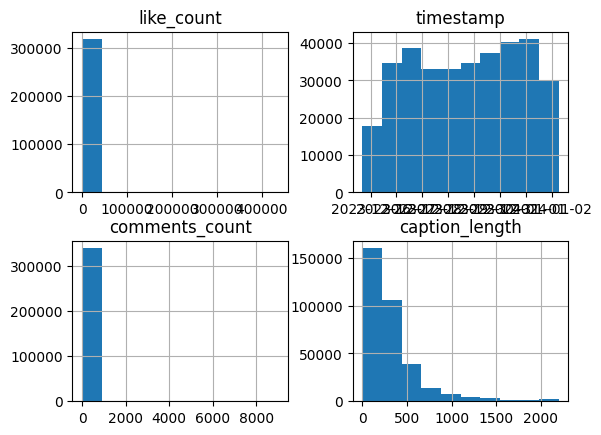

In [ ]:
# TODO: maybe show also distribution of media
df_posts[["like_count","timestamp","comments_count","caption_length"]].hist()
pass

We can see also considering the description that the values for the caption length seem realistic especially when considering the maximum length for a caption for instagram posts is 2200 characters, which can be see also as a maximum value for the caption length in our dataset. But what is suspicious that in created description table the minimum caption length is one, but our smallest hashtag #war has at least a length of four

For the like count and comment count,it can be observerd that it 0 for a lost posts, this is because we grab posts published at latest 24 hours before we grab them. Both columns could be not intresting for us because we get the recent posts and we grab tham at different time points. For example one post can be grabbed two minutes after it appeared whereas an nother post is grabed 20 hours after it appeared. Nevertheless we think we can use the like and comment count to plot the values for analysis, because this problem is for all posts and not only for posts of a special hashtag.




In [ ]:
df_posts[df_posts["caption_length"] <= 4].head(50)

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,media_url,id,caption_length
704492,6593afc4c036509d41c7083b,صح 👍,18245.0,https://www.instagram.com/p/C1jsQWwtbty/,2024-01-01 12:29:29+00:00,IMAGE,174,https://scontent-mad1-1.cdninstagram.com/v/t51...,18026858374723879,4
704383,6593afc4c036509d41c707ce,🧡🧡🧡🧡,2801.0,https://www.instagram.com/p/C1jtJXrtb7F/,2024-01-01 12:37:16+00:00,IMAGE,27,https://scontent-mad2-1.cdninstagram.com/v/t51...,17967571244529406,4
698101,6593afc3c036509d41c6ef44,♡,NaN,https://www.instagram.com/p/C1kcF8vLgcp/,2024-01-01 19:27:30+00:00,IMAGE,2,https://scontent-mad2-1.cdninstagram.com/v/t51...,17859377730081428,1
696494,6593afc3c036509d41c6e8fd,♥️,4.0,https://www.instagram.com/reel/C1kqIawr3DM/,2024-01-01 21:44:08+00:00,VIDEO,3,NaN,18409514869045412,2
695010,6593afc3c036509d41c6e331,🇳🇱,1.0,https://www.instagram.com/p/C1lCvfmC81m/,2024-01-02 01:05:13+00:00,IMAGE,1,https://scontent-mad2-1.cdninstagram.com/v/t51...,17969317544676042,2
694999,6593afc3c036509d41c6e326,🇬🇧,2.0,https://www.instagram.com/p/C1lC6c4iG9T/,2024-01-02 01:06:43+00:00,IMAGE,1,https://scontent-mad1-1.cdninstagram.com/v/t51...,18006358172268789,2
687400,659399e1c036509d41c6c577,💙🇮🇱,NaN,https://www.instagram.com/p/C1kPFE9seaE/,2024-01-01 17:33:47+00:00,CAROUSEL_ALBUM,29,NaN,17848585857115095,3
685446,659399e1c036509d41c6bdd5,💙 🤍,6.0,https://www.instagram.com/p/C1kTDEhu56N/,2024-01-01 18:08:28+00:00,CAROUSEL_ALBUM,1,NaN,18026693860853325,3
667234,659371dac036509d41c676b1,#war,0.0,https://www.instagram.com/p/C1kqbL5SGDO/,2024-01-01 21:32:44+00:00,IMAGE,0,https://scontent-mad1-1.cdninstagram.com/v/t51...,18220644775251075,4
664863,65934475c036509d41c66d6e,2024,108.0,https://www.instagram.com/p/C1iSvCCtUek/,2023-12-31 23:27:15+00:00,IMAGE,2,https://scontent-mad1-1.cdninstagram.com/v/t51...,18028105531832074,4


In [ ]:
len(df_posts[df_posts["caption_length"]  <= 4])

124

I would assume one reason is because we had some issues in the beginning of data collection process, for example that for one or two executions, we grabed messages for the first letter of the hashtag and not the hashtag it self. Additionally with further research, which was not clarified at the instagram page, I found out that when using the search bar of instagram, not only posts which contain the hashtag in the caption, but also in the comments are shown. I assume this is also the case when calling the endpoint for instagram. For example for the post in row 3, the permalink is https://www.instagram.com/p/C1kcF8vLgcp/. When openning the permalink, it can be seen that the creator of the post made comment containing the hashtag palestine.

In [ ]:
hashtags = ["#gaza","#israel","#palestine","#war","#freepalestine","#BringThemHomeNow","#standwithisrael"]

def filterfunc(row):
    caption = row["caption"]
    #for instagram there is no difference in hastags for capital letters
    caption = caption.lower()
    for hashtag in hashtags:
        if hashtag in caption:
            return True
    
    return False
    

inlcudes_one_of_our_hashtags = df_posts.apply(filterfunc,axis=1)
df_posts[inlcudes_one_of_our_hashtags].describe()

,like_count,comments_count,id,caption_length
count,300268.000000,321017.000000,3.210170e+05,321017.000000
mean,113.044014,5.065183,1.803504e+16,324.161848
std,2026.833732,59.610926,1.263131e+14,337.521828
min,0.000000,0.000000,1.784268e+16,4.000000
25%,1.000000,0.000000,1.797537e+16,105.000000
50%,4.000000,0.000000,1.801264e+16,234.000000
75%,20.000000,1.000000,1.804990e+16,409.000000
max,436327.000000,9011.000000,1.859401e+16,2200.000000


In [ ]:
print(f"So we have in total {len(df_posts) - inlcudes_one_of_our_hashtags.sum()} posts that contain not one of our hashtags in the caption")

So we have in total 19241 posts that contain not one of our hashtags in the caption


In [ ]:
# I decided to delete them, because it is a small part of our data and we want to focus in the analysis on hashtags.
df_posts = df_posts[inlcudes_one_of_our_hashtags]
len(df_posts)

321017

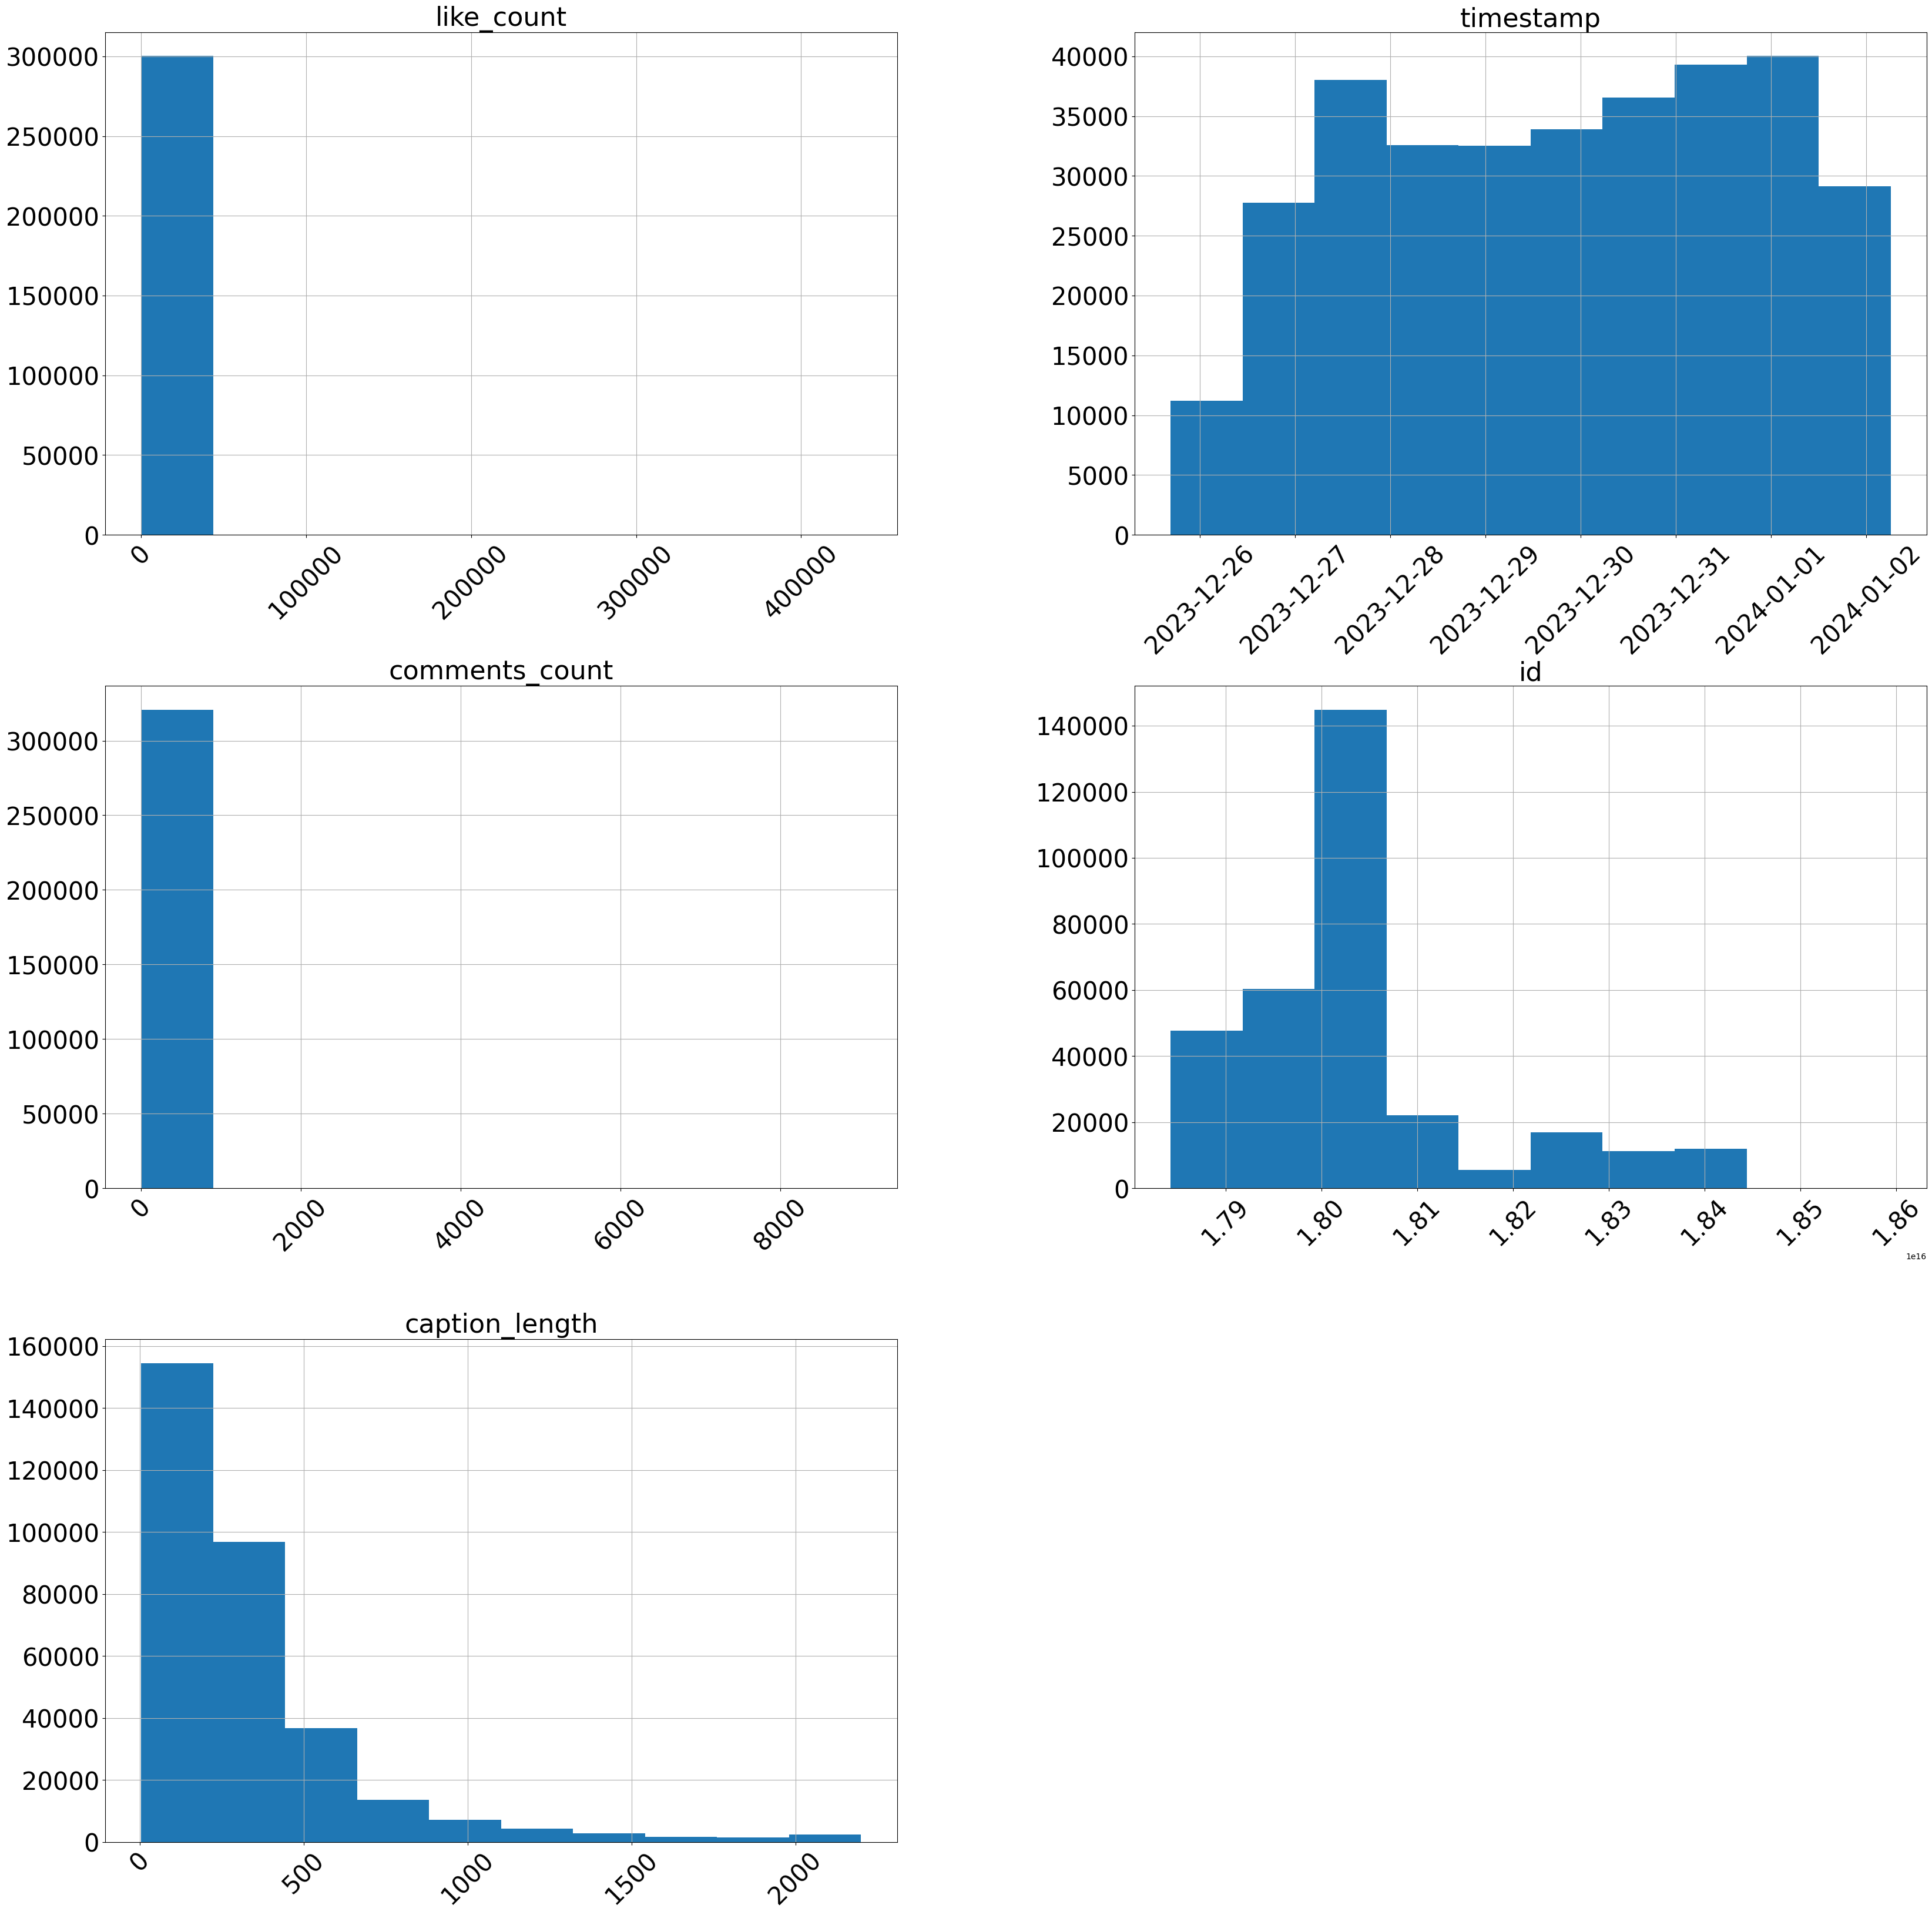

In [ ]:
# always look at the data
fig = df_posts.hist(xrot=45,figsize=(40,40), xlabelsize=30, ylabelsize=30)
[x.title.set_size(32) for x in fig.ravel()]
pass

In [ ]:
df_posts["caption"].head()
for x in df_posts["caption"].head(10):
    print(x)

Palestine in 1928, almost 100 years ago 🇵🇸
Footage of Jerusalem and Haifa 📍
•
#freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn
-خصم خاص و مميز للمجموعات 
Custom Jackets, Hoodies, and t-shirts 
For all of our products and services please contact us via DM or WhatsApp

حابب تستفسر .. اتواصل معنا 
📞0796019220
#school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت
We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September.

<Axes: >

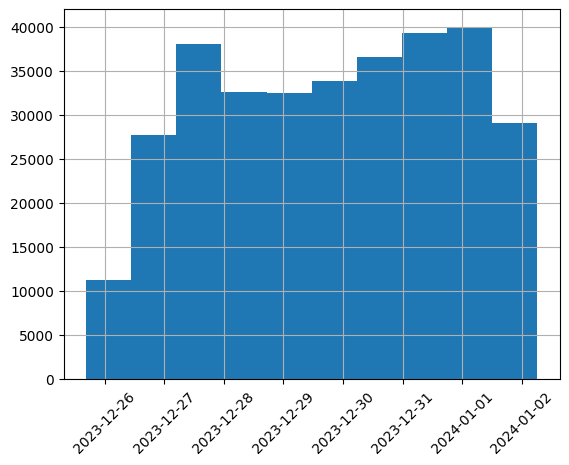

In [ ]:
# focus more on timestamps
df_posts["timestamp"].hist(xrot=45)

Here it can be also seen that the we started on 26 to grab messages till the start of 02.01.2024. On the 26 we grabbed less messages, the reason I think that our data collection process was not working well on the first day. I could also delete the messages found there, but I see not a strong reason for doing that.

## 1.6 Final view of cleaned data set

In [187]:

print(f"number of toal documents in mongo db: {posts.count_documents({})}")
print(f"number of posts after cleaning database: {len(df_posts)}")
print(f"number of messages cleaned {posts.count_documents({}) - len(df_posts)}")

ServerSelectionTimeoutError: localhost:27017: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte, Timeout: 30s, Topology Description: <TopologyDescription id: 65967694d7470ef7559187d8, topology_type: Single, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte')>]>

# 2. Data Analysis

In this part I will do the following tasks:

0. Add additional fields like for language and for sensitivity
1. Plot the hashtags occurence in the data in general
    - For my problem the question which hashtags occure mostly is imortant
2. Plot for specific hashtags
    - Considering the war hashtag how important is the palestine israel war
    - What are the opinions for that come with the palestine hashtag
    - What are opionions which come with the Isreal hashtag
3. Is there any bias with the language?
    - is 
4. is there any bias with the time?
5. Is there any bias with the media type?
6. Senitment analysis

In [ ]:
import re

# define a function to find all hashtags out of a text
def hashtags_inlcuded_In_text(text):
    hashtags = re.findall(r'#\w+', text.lower())

    #remove duplicates, dictionaries can not have duplicate keys
    hashtags = list(dict.fromkeys(hashtags))

    return hashtags

# for example
print(hashtags_inlcuded_In_text("asdfasdf #gaza#war asdfasdfasdf #thisIsAnExample#big_data_analytics_is_fun #GAza#WaR #gaza_war"))

'#war' in ["#gaza_war"]

['#gaza', '#war', '#thisisanexample', '#big_data_analytics_is_fun', '#gaza_war']


False

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_hashtag_occurence(posts_dataframe):
    #create empty dictionary
    hashtag_amount = {}

    for hashtags_in_one_row in posts_dataframe["hashtags"]:
        for hashtag in hashtags_in_one_row:
            # check if hashtag is found first time
            if hashtag not in hashtag_amount:
                hashtag_amount[hashtag] = 0
            hashtag_amount[hashtag] = hashtag_amount[hashtag] + 1
        
    sorted_items = sorted(hashtag_amount.items(), key=lambda x: x[1], reverse=True)
    top_items = sorted_items[:20]

    print("Top hashtags:")
    print(top_items)
    # Extract items and their counts for plotting
    items, counts = zip(*top_items)

    averate_sensitivity = [ df_posts[df_posts.apply(lambda x: hashtag in  x["hashtags"],axis=1)]["sensitivity"].mean() for hashtag in items]



    # Plotting the bar chart
    plt.bar(items, counts, color='blue')
    plt.xlabel('Unique Items')
    plt.ylabel('Count')
    plt.title('Count of Unique Items')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    plt.bar(items, averate_sensitivity, color="blue")
    plt.xlabel('Unique Items')
    plt.ylabel('Average')
    plt.title('Average sensitivity of Unique Items')
    plt.xticks(rotation=45, ha='right')
    plt.show()





In [ ]:
# to see the full caption
pd.set_option('display.max_colwidth', None)

In [ ]:
# add new column with unique hashtags occuring in one line
df_posts.loc[:, "hashtags"] = df_posts.apply(lambda x: hashtags_inlcuded_In_text(x["caption"]), axis=1)

In [ ]:
df_posts.loc[:,("caption", "hashtags")]

,caption,hashtags
709030,"Palestine in 1928, almost 100 years ago 🇵🇸 Footage of Jerusalem and Haifa 📍 • #freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn","[#freepalestine, #palestine, #jerusalem, #history, #rightofreturn, #aidoun, #alquds, #savealquds, #alqudscapitalofpalestine, #ceasefire, #ceasefirenow, #palestina, #gaza, #gazaunderattack, #gazagenocide, #savegaza, #palestinian, #stopgenocide, #ethniccleansing, #massmurder, #stopfundingisrael, #fromtherivertothesea, #fromtherivertotheseapalestinewillbefree]"
709029,"-خصم خاص و مميز للمجموعات Custom Jackets, Hoodies, and t-shirts For all of our products and services please contact us via DM or WhatsApp حابب تستفسر .. اتواصل معنا 📞0796019220 #school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت","[#school, #jordan, #amman, #newcollection, #jacket, #senior, #seniorjacket, #graduation, #palestine, #ksa, #جاكيت]"
709028,"We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September. We enjoyed this amazing day , thank you for attending . See in our next Fashion Show . #LFW#londonfashionweek#milanofashionweek#nevenelkady#NK#olivecollection#palestine","[#lfw, #londonfashionweek, #milanofashionweek, #nevenelkady, #nk, #olivecollection, #palestine]"
709027,"If u support 🇵🇸 Like❤️ & share, comment>> #FreePalestine #gaza 🍉🏴🤍 Please.. Follow for more Help me to reach 3k:) فلسطين حرة🏳️🤍🕊️ . . . Bismillah... motaz_azaiza #fyp #reels #muslim #islamic #content #palestine #israel #ceasefirenow🇵🇸 #ongaza #aesthetic #birds #pinterest #video #help #mosque #alaqsa #victory #fromzionism #support #humanity #trend #nasheed #like #follow #comment #share #atounaeltoufouli","[#freepalestine, #gaza, #fyp, #reels, #muslim, #islamic, #content, #palestine, #israel, #ceasefirenow, #ongaza, #aesthetic, #birds, #pinterest, #video, #help, #mosque, #alaqsa, #victory, #fromzionism, #support, #humanity, #trend, #nasheed, #like, #follow, #comment, #share, #atounaeltoufouli]"
709026,"Kadang mikir: mereka udah makan belum ya? Mereka udah minum blm ya? Mereka tidurnya dimana sekarang? Ada yang kelaparan, kedinginan, kehausan gak ya? Dll #palestine #palestine🇵🇸 #allah #allahswt #muslim #islam #islamicquotes #islamicposts #allahuakbar #freepalestine🇵🇸 #savepalestine🇵🇸 #aqsa #quotes #viral #fyp #fypシ","[#palestine, #allah, #allahswt, #muslim, #islam, #islamicquotes, #islamicposts, #allahuakbar, #freepalestine, #savepalestine, #aqsa, #quotes, #viral, #fyp, #fypシ]"
...,...,...
703952,#gaza #palestine #trending #video #viral #viralvideos #emotion_daily #allhamdullilahforeverything❤️,"[#gaza, #palestine, #trending, #video, #viral, #viralvideos, #emotion_daily, #allhamdullilahforeverything]"
703951,Beshaq ♥️🥀☆♡ ... ... Like share comment #Allah #muhammadﷺ #deen #dua #madinah #palestine #gaza #trending Follow aliyashaikhh0,"[#allah, #muhammadﷺ, #deen, #dua, #madinah, #palestine, #gaza, #trending]"
703950,Demonstrasi jutaan orang di Istanbul menuntut diakhirinya agresi terhadap Gaza. #stopgenocideingaza #gazaunderattack #savegaza #savepalestine #gaza #palestine #freepalestine #freepalestine🇵🇸 #freepalestine_now #palestinewillbefree #ceasefirenow #ceasefirenow🇵🇸 #permanentceasefirenow,"[#stopgenocideingaza, #gazaunderattack, #savegaza, #savepalestine, #gaza, #palestine, #freepalestine, #freepalestine_now, #palestinewillbefree, #ceasefirenow, #permanentceasefirenow]"
703949,"Bütün dünya yeni ili qeyd edərkən Qəzza əhalisi bu vəziyyətdədir🥺 Uca Allah(c.c) bu məzlu

In [ ]:
# it functions and also we can look after specific hashtags easily
for x in df_posts["hashtags"].head(3):
    print(x)
    print("#war" in x)
    print("#film" in x)

['#freepalestine', '#palestine', '#jerusalem', '#history', '#rightofreturn', '#aidoun', '#alquds', '#savealquds', '#alqudscapitalofpalestine', '#ceasefire', '#ceasefirenow', '#palestina', '#gaza', '#gazaunderattack', '#gazagenocide', '#savegaza', '#palestinian', '#stopgenocide', '#ethniccleansing', '#massmurder', '#stopfundingisrael', '#fromtherivertothesea', '#fromtherivertotheseapalestinewillbefree']
False
False
['#school', '#jordan', '#amman', '#newcollection', '#jacket', '#senior', '#seniorjacket', '#graduation', '#palestine', '#ksa', '#جاكيت']
False
False
['#lfw', '#londonfashionweek', '#milanofashionweek', '#nevenelkady', '#nk', '#olivecollection', '#palestine']
False
False


In [ ]:
df_posts.isnull().sum()

_id                 0
caption             0
like_count        423
permalink           0
timestamp           0
media_type          0
comments_count      0
id                  0
caption_length      0
hashtags            0
dtype: int64

### 0. Adding additional fields: language field

In [ ]:
# adding a column for indicating the language
from langdetect import detect

def detect_language(row):
    try:
        detected_language = detect(row["caption"])
        return detected_language
    except Exception as e:
        print("An error occurred:", e)
        print(row["caption"])
        return None

df_posts["language"] = df_posts.apply(detect_language ,axis=1)



An error occurred: No features in text.
#islam #istandwithpalestine🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵 #palestine #gaza #gazanation
An error occurred: No features in text.
ប្រទេស​អ៊ីស្រាអែល​បាន​បើក​ការ​វាយ​ប្រហារ​ថ្មី​ដោយ​ការ​ទម្លាក់​គ្រាប់បែក​លើ​ក្រុម​សកម្ម​ប្រយុទ្ធ​ហាម៉ាស់ (Hamas) កាលពី​ថ្ងៃ​អាទិត្យ។ មន្ត្រី​សុខាភិបាល​បាន​និយាយ​ថា មនុស្ស​យ៉ាង​តិច ៣៥ នាក់​ត្រូវ​បាន​សម្លាប់​នៅ​ក្នុង​ទីក្រុង​ហ្កាហ្សា (Gaza) ហើយ​គ្មាន​សញ្ញា​ណា​មួយ​ដែល​បង្ហាញ​ថា​ការ​ប្រយុទ្ធ​គ្នា​នេះ​នឹង​បញ្ចប់​ក្នុង​ពេល​ឆាប់ៗ​ខាង​មុខ​នេះ​នៅ​ពេល​ដែល​ឆ្នាំ​ថ្មី ​ឆ្នាំ ២០២៤ ចូល​មក​ដល់​នោះ​ទេ។

កងទ័ព​អ៊ីស្រាអែល​បាន​វាយ​ប្រហារ​លើ​ផ្នែក​ភាគ​កណ្ដាល​នៃ​តំបន់​ហ្កាហ្សា ហើយ​ក៏​ធ្វើ​ប្រតិបត្តិការ​វាយ​ប្រហារ​នៅ​ក្នុង​ទីក្រុង Khan Younis ដែល​ជា​ទីក្រុង​ធំ​ជាង​គេ​បង្អស់​ទី​ពីរ​នៅ​ក្នុង​ភាគ​ខាង​ត្បូង​នៃ​តំបន់​នេះ​ជិត​ព្រំដែន​ជាប់​ប្រទេស​អេហ្ស៊ីប​ផង​ដែរ។

នាយករដ្ឋមន្ត្រី​អ៊ីស្រាអែល​លោក Benjamin Netanyahu បាន​ព្យាករណ៍​កាលពី​ថ្ងៃ​សៅរ៍​ថា ការ​វាយ

In [ ]:
# always look at the data
df_posts[['caption','language']].head()
   

,caption,language
709030,"Palestine in 1928, almost 100 years ago 🇵🇸 Footage of Jerusalem and Haifa 📍 • #freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn",en
709029,"-خصم خاص و مميز للمجموعات Custom Jackets, Hoodies, and t-shirts For all of our products and services please contact us via DM or WhatsApp حابب تستفسر .. اتواصل معنا 📞0796019220 #school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت",en
709028,"We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September. We enjoyed this amazing day , thank you for attending . See in our next Fashion Show . #LFW#londonfashionweek#milanofashionweek#nevenelkady#NK#olivecollection#palestine",en
709027,"If u support 🇵🇸 Like❤️ & share, comment>> #FreePalestine #gaza 🍉🏴🤍 Please.. Follow for more Help me to reach 3k:) فلسطين حرة🏳️🤍🕊️ . . . Bismillah... motaz_azaiza #fyp #reels #muslim #islamic #content #palestine #israel #ceasefirenow🇵🇸 #ongaza #aesthetic #birds #pinterest #video #help #mosque #alaqsa #victory #fromzionism #support #humanity #trend #nasheed #like #follow #comment #share #atounaeltoufouli",en
709026,"Kadang mikir: mereka udah makan belum ya? Mereka udah minum blm ya? Mereka tidurnya dimana sekarang? Ada yang kelaparan, kedinginan, kehausan gak ya? Dll #palestine #palestine🇵🇸 #allah #allahswt #muslim #islam #islamicquotes #islamicposts #allahuakbar #freepalestine🇵🇸 #savepalestine🇵🇸 #aqsa #quotes #viral #fyp #fypシ",id


It funcitons to 70% correctly. The first one and the forth one is incorrect, the languange from the first one has to be turkish and last one is not really detectable. Also when only hashtags occur, than there is a probability that these hastags are in english. But I think this is not a major problem, also because hashtags can be also in other languages, I not want to remove posts that contain only hashtags.

In [ ]:
# look how much posts only contain hashtags

In [ ]:
# change typ to category

df_posts = df_posts.astype({'language':'category'})
df_posts.dtypes

_id                    string[python]
caption                string[python]
like_count                    float64
permalink              string[python]
timestamp         datetime64[ns, UTC]
media_type                   category
comments_count                  int64
id                              int64
caption_length                  int64
hashtags                       object
language                     category
dtype: object

In [ ]:
# seems that only 90 messages have nothing standing ther
df_posts['language'].isnull().sum()


2

In [ ]:
# observe how nan stands for null
for x in df_posts['language'].unique():
    print(x)

en
id
es
fr
it
ar
fi
tr
fa
ca
no
af
et
ja
sl
nl
hi
hr
ru
so
ta
ur
ro
nan
tl
pt
de
bn
lt
bg
pl
sv
he
ml
sw
gu
ne
sq
mk
pa
th
lv
te


In [ ]:
df_posts[df_posts["language"].isnull()]

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length,hashtags,language
708585,6593afc4c036509d41c71838,#islam #istandwithpalestine🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵🇸🇵 #palestine #gaza #gazanation,14.0,https://www.instagram.com/reel/C1jIZDRrwBA/,2024-01-01 07:16:26+00:00,VIDEO,0,18043121725606144,187,"[#islam, #istandwithpalestine, #palestine, #gaza, #gazanation]",NaN
704606,6593afc4c036509d41c708ad,ប្រទេស​អ៊ីស្រាអែល​បាន​បើក​ការ​វាយ​ប្រហារ​ថ្មី​ដោយ​ការ​ទម្លាក់​គ្រាប់បែក​លើ​ក្រុម​សកម្ម​ប្រយុទ្ធ​ហាម៉ាស់ (Hamas) កាលពី​ថ្ងៃ​អាទិត្យ។ មន្ត្រី​សុខាភិបាល​បាន​និយាយ​ថា មនុស្ស​យ៉ាង​តិច ៣៥ នាក់​ត្រូវ​បាន​សម្លាប់​នៅ​ក្នុង​ទីក្រុង​ហ្កាហ្សា (Gaza) ហើយ​គ្មាន​សញ្ញា​ណា​មួយ​ដែល​បង្ហាញ​ថា​ការ​ប្រយុទ្ធ​គ្នា​នេះ​នឹង​បញ្ចប់​ក្នុង​ពេល​ឆាប់ៗ​ខាង​មុខ​នេះ​នៅ​ពេល​ដែល​ឆ្នាំ​ថ្មី ​ឆ្នាំ ២០២៤ ចូល​មក​ដល់​នោះ​ទេ។ កងទ័ព​អ៊ីស្រាអែល​បាន​វាយ​ប្រហារ​លើ​ផ្នែក​ភាគ​កណ្ដាល​នៃ​តំបន់​ហ្កាហ្សា ហើយ​ក៏​ធ្វើ​ប្រតិបត្តិការ​វាយ​ប្រហារ​នៅ​ក្នុង​ទីក្រុង Khan Younis ដែល​ជា​ទីក្រុង​ធំ​ជាង​គេ​បង្អស់​ទី​ពីរ​នៅ​ក្នុង​ភាគ​ខាង​ត្បូង​នៃ​តំបន់​នេះ​ជិត​ព្រំដែន​ជាប់​ប្រទេស​អេហ្ស៊ីប​ផង​ដែរ។ នាយករដ្ឋមន្ត្រី​អ៊ីស្រាអែល​លោក Benjamin Netanyahu បាន​ព្យាករណ៍​កាលពី​ថ្ងៃ​សៅរ៍​ថា ការ​វាយ​ប្រហារ​របស់​អ៊ីស្រាអែល​នេះ​ដែល​បង្ក​ឡើង​ដោយ​ការ​វាយ​ប្រហារ​ដ៏​ភ្ញាក់ផ្អើល​របស់​ក្រុម​ហាម៉ាស់​លើ​អ៊ីស្រាអែល​កាលពី​ថ្ងៃ​ទី ៧ ខែ​តុលា​ឆ្នាំ​មុន ​នឹង​បន្ត​រយៈពេល «ជាច្រើន​ខែ» ទោះបីជា​មាន​ការ​អំពាវ នាវ​កើនឡើង​ពី​អន្តរជាតិ​ឱ្យ​មាន​កិច្ចឈប់បាញ់​គ្នា​ក៏ដោយ។ ក្រសួង​សុខាភិបាល​ដែល​គ្រប់គ្រង​ដោយ​ក្រុម​ហាម៉ាស់​បាន​បញ្ជាក់​ថា សាកសព ១៨ នាក់​ត្រូវ​បាន​រកឃើញ​នៅ​ក្នុង​ការ​ទម្លាក់​គ្រាប់បែក​លើ​ទីក្រុង​ហ្កាហ្សា​កាលពី​យប់មិញ ដោយ​សាកសព​ជា​ច្រើន​ទៀត​ត្រូវ​គេ​ជឿ​ថា​បាន​កប់​នៅ​ក្រោម​គំនរ​បាក់បែក។ យោធា​អ៊ីស្រាអែល​បាន​បញ្ជាក់​ថា ខ្លួន​បាន​សម្លាប់​សត្រូវ​ប្រហែល ១២ នាក់​ នៅ​ក្នុង​សមរភូមិ​ផ្លូវ​គោក​ជា​ច្រើន​និង​នៅ​ក្នុង​ការ​វាយ​ប្រហារ​តាម​អាកាស​និង​ការ​វាយ​ប្រហារ​ដោយ​រថក្រោះ។ យោធា​នេះ​បាន​បន្ថែម​ថា ខ្លួន​បាន​រកឃើញ​ផ្លូវ​រូង​ក្រោមដី​របស់​ក្រុម​ហាម៉ាស់​បន្ថែម​ទៀត​និង​គ្រាប់ផ្ទុះ​ដែល​បង្កប់​នៅ​ក្នុង​សាលាមត្តេយ្យ​មួយ​កន្លែង។ ស្របពេល​ដែល​សង្គ្រាម​នេះ​ឈាន​ចូល​ជិត ៣ ខែ​ពេញ មនុស្ស​ប្រហែល ៨៥% នៃ​ប្រជាជន​សរុប​ចំនួន ២ លាន ៣ សែន​នាក់​ នៅ​ក្នុង​តំបន់​ហ្កាហ្សា​ត្រូវ​បាន​បង្ខំ​ខ្លួន​គេចចេញ​ពី​ផ្ទះ​សម្បែង។ នេះ​បើ​យោង​តាម​អង្គការ​សហប្រជាជាតិ។ អង្គការ​សហប្រជាជាតិ​បាន​ព្រមាន​អំពី​ហានិភ័យ​កើនឡើង​នៃ​ភាព​អត់ឃ្លាន​និង​ជំងឺ​នៅ​ពេល​ដែល​ក្រុម​គ្រួសារ​ដ៏​អស់​សង្ឃឹម​នានា​ជ្រកកោន​នៅ​ក្នុង​តង់​បណ្ដោះ អាសន្ន​ការពារ​ពី​ធាតុអាកាស​ត្រជាក់​ក្នុង​រដូវ​រងា។ លោក Netanyahu បាន​និយាយ​នៅ​ក្នុង​សន្និសីទ​កាសែត​កាលពី​ថ្ងៃ​សៅរ៍​ថា តំបន់​ព្រំដែន​រវាង​តំបន់​ហ្កាហ្សា​និង​ប្រទេស​អេហ្ស៊ីប​គួរតែ​ស្ថិត​ក្រោម​ការ​គ្រប់គ្រង​របស់​អ៊ីស្រាអែល​ដើម្បី​ធានា​ថា​តំបន់​នោះ​គ្មាន​យោធា៕ #israelhamaswar #gaza #palestine #israel,6.0,https://www.instagram.com/p/C1jrkOVMrD0/,2024-01-01 12:23:28+00:00,CAROUSEL_ALBUM,0,18220275292250008,2195,"[#israelhamaswar, #gaza, #palestine, #israel]",NaN


In [ ]:
# get lenguage full names
from iso639 import languages
# Todo: fix this

def get_language_full_name(x):
    try:
        if 'language' in x:
            return languages.get(alpha2=x['language']).name
        else:
            return None

    except Exception as e:
        print(f"error:{e}")
        return None




df_posts["language_fullname"] = df_posts.apply(get_language_full_name,axis=1)

error:nan
error:nan


In [ ]:
df_posts.head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length,hashtags,language,language_fullname
709030,6593afc4c036509d41c719f5,"Palestine in 1928, almost 100 years ago 🇵🇸 Footage of Jerusalem and Haifa 📍 • #freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn",4.0,https://www.instagram.com/reel/C1Pc6AuOQOp/,2024-01-02 04:01:43+00:00,VIDEO,1,18319275220191198,487,"[#freepalestine, #palestine, #jerusalem, #history, #rightofreturn, #aidoun, #alquds, #savealquds, #alqudscapitalofpalestine, #ceasefire, #ceasefirenow, #palestina, #gaza, #gazaunderattack, #gazagenocide, #savegaza, #palestinian, #stopgenocide, #ethniccleansing, #massmurder, #stopfundingisrael, #fromtherivertothesea, #fromtherivertotheseapalestinewillbefree]",en,English
709029,6593afc4c036509d41c719f4,"-خصم خاص و مميز للمجموعات Custom Jackets, Hoodies, and t-shirts For all of our products and services please contact us via DM or WhatsApp حابب تستفسر .. اتواصل معنا 📞0796019220 #school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت",9.0,https://www.instagram.com/reel/C1jgXbWIJtO/,2024-01-01 10:45:00+00:00,VIDEO,0,18005010503248089,290,"[#school, #jordan, #amman, #newcollection, #jacket, #senior, #seniorjacket, #graduation, #palestine, #ksa, #جاكيت]",en,English
709028,6593afc4c036509d41c719f3,"We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September. We enjoyed this amazing day , thank you for attending . See in our next Fashion Show . #LFW#londonfashionweek#milanofashionweek#nevenelkady#NK#olivecollection#palestine",7.0,https://www.instagram.com/p/C1j2n3Yy7D-/,2024-01-01 14:00:00+00:00,IMAGE,0,17919524468832008,391,"[#lfw, #londonfashionweek, #milanofashionweek, #nevenelkady, #nk, #olivecollection, #palestine]",en,English
709027,6593afc4c036509d41c719f2,"If u support 🇵🇸 Like❤️ & share, comment>> #FreePalestine #gaza 🍉🏴🤍 Please.. Follow for more Help me to reach 3k:) فلسطين حرة🏳️🤍🕊️ . . . Bismillah... motaz_azaiza #fyp #reels #muslim #islamic #content #palestine #israel #ceasefirenow🇵🇸 #ongaza #aesthetic #birds #pinterest #video #help #mosque #alaqsa #victory #fromzionism #support #humanity #trend #nasheed #like #follow #comment #share #atounaeltoufouli",55.0,https://www.instagram.com/reel/C1lW113RAFJ/,2024-01-02 04:00:54+00:00,VIDEO,2,18050723722551206,412,"[#freepalestine, #gaza, #fyp, #reels, #muslim, #islamic, #content, #palestine, #israel, #ceasefirenow, #ongaza, #aesthetic, #birds, #pinterest, #video, #help, #mosque, #alaqsa, #victory, #fromzionism, #support, #humanity, #trend, #nasheed, #like, #follow, #comment, #share, #atounaeltoufouli]",en,English
709026,6593afc4c036509d41c719f1,"Kadang mikir: mereka udah makan belum ya? Mereka udah minum blm ya? Mereka tidurnya dimana sekarang? Ada yang kelaparan, kedinginan, kehausan gak ya? Dll #palestine #palestine🇵🇸 #allah #allahswt #muslim #islam #islamicquotes #islamicposts #allahuakbar #freepalestine🇵🇸 #savepalestine🇵🇸 #aqsa #quotes #viral #fyp #fypシ",159.0,https://www.instagram.com/p/C1lghjyJPj6/,2024-01-02 05:25:14+00:00,IMAGE,13,17921710193827745,318,"[#palestine, #allah, #allahswt, #muslim, #islam, #islamicquotes, #islamicposts, #allahuakbar, #freepalestine, #savepalestine, #aqsa, #quotes, #viral, #fyp, #fypシ]",id,Indonesian


### 0. Adding additional fields: sensitivity

for the sensitivity analysis we will user VADER (Valence Aware Dictionary and sEntiment Reasoner) https://github.com/cjhutto/vaderSentiment. Vadder is designed specifically for sentiment analysis expressed in social media. Espeacially it can translats text before applying any sensitiyity analysis. It ouputs three secores:

- compound: It is a score between -1 (extremly negative) and 1 (extremly positiv)

The next scores should add up to 1.
- neg: ratio of text beeing negative
- pos: ratio of text beeing positive
- neu: ratio of text beeing neutral

For my analysis the compound score is enough.

In [182]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()



df_posts["sensitivity"] = df_posts.apply(lambda x: analyzer.polarity_scores(x["caption"])["compound"], axis=1)



In [183]:
#TODO: how good the analysis
df_posts.head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length,hashtags,language,language_fullname,sensitivity
709030,6593afc4c036509d41c719f5,"Palestine in 1928, almost 100 years ago 🇵🇸 Footage of Jerusalem and Haifa 📍 • #freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn",4.0,https://www.instagram.com/reel/C1Pc6AuOQOp/,2024-01-02 04:01:43+00:00,VIDEO,1,18319275220191198,487,"[#freepalestine, #palestine, #jerusalem, #history, #rightofreturn, #aidoun, #alquds, #savealquds, #alqudscapitalofpalestine, #ceasefire, #ceasefirenow, #palestina, #gaza, #gazaunderattack, #gazagenocide, #savegaza, #palestinian, #stopgenocide, #ethniccleansing, #massmurder, #stopfundingisrael, #fromtherivertothesea, #fromtherivertotheseapalestinewillbefree]",en,English,0.0000
709029,6593afc4c036509d41c719f4,"-خصم خاص و مميز للمجموعات Custom Jackets, Hoodies, and t-shirts For all of our products and services please contact us via DM or WhatsApp حابب تستفسر .. اتواصل معنا 📞0796019220 #school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت",9.0,https://www.instagram.com/reel/C1jgXbWIJtO/,2024-01-01 10:45:00+00:00,VIDEO,0,18005010503248089,290,"[#school, #jordan, #amman, #newcollection, #jacket, #senior, #seniorjacket, #graduation, #palestine, #ksa, #جاكيت]",en,English,0.7579
709028,6593afc4c036509d41c719f3,"We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September. We enjoyed this amazing day , thank you for attending . See in our next Fashion Show . #LFW#londonfashionweek#milanofashionweek#nevenelkady#NK#olivecollection#palestine",7.0,https://www.instagram.com/p/C1j2n3Yy7D-/,2024-01-01 14:00:00+00:00,IMAGE,0,17919524468832008,391,"[#lfw, #londonfashionweek, #milanofashionweek, #nevenelkady, #nk, #olivecollection, #palestine]",en,English,0.9480
709027,6593afc4c036509d41c719f2,"If u support 🇵🇸 Like❤️ & share, comment>> #FreePalestine #gaza 🍉🏴🤍 Please.. Follow for more Help me to reach 3k:) فلسطين حرة🏳️🤍🕊️ . . . Bismillah... motaz_azaiza #fyp #reels #muslim #islamic #content #palestine #israel #ceasefirenow🇵🇸 #ongaza #aesthetic #birds #pinterest #video #help #mosque #alaqsa #victory #fromzionism #support #humanity #trend #nasheed #like #follow #comment #share #atounaeltoufouli",55.0,https://www.instagram.com/reel/C1lW113RAFJ/,2024-01-02 04:00:54+00:00,VIDEO,2,18050723722551206,412,"[#freepalestine, #gaza, #fyp, #reels, #muslim, #islamic, #content, #palestine, #israel, #ceasefirenow, #ongaza, #aesthetic, #birds, #pinterest, #video, #help, #mosque, #alaqsa, #victory, #fromzionism, #support, #humanity, #trend, #nasheed, #like, #follow, #comment, #share, #atounaeltoufouli]",en,English,0.9633
709026,6593afc4c036509d41c719f1,"Kadang mikir: mereka udah makan belum ya? Mereka udah minum blm ya? Mereka tidurnya dimana sekarang? Ada yang kelaparan, kedinginan, kehausan gak ya? Dll #palestine #palestine🇵🇸 #allah #allahswt #muslim #islam #islamicquotes #islamicposts #allahuakbar #freepalestine🇵🇸 #savepalestine🇵🇸 #aqsa #quotes #viral #fyp #fypシ",159.0,https://www.instagram.com/p/C1lghjyJPj6/,2024-01-02 05:25:14+00:00,IMAGE,13,17921710193827745,318,"[#palestine, #allah, #allahswt, #muslim, #islam, #islamicquotes, #islamicposts, #allahuakbar, #freepalestine, #savepalestine, #aqsa, #quotes, #viral, #fyp, #fypシ]",id,Indonesian,0.0000


In [184]:
# I have
df_posts[df_posts["caption_length"] > 100].head()

,_id,caption,like_count,permalink,timestamp,media_type,comments_count,id,caption_length,hashtags,language,language_fullname,sensitivity
709030,6593afc4c036509d41c719f5,"Palestine in 1928, almost 100 years ago 🇵🇸 Footage of Jerusalem and Haifa 📍 • #freepalestine #palestine #jerusalem #history #rightofreturn #aidoun #alquds #savealquds #alqudscapitalofpalestine #ceasefire #ceasefirenow🇵🇸 #palestine #palestina #gaza #gazaunderattack #gazagenocide #savegaza #palestinian #stopgenocide #ethniccleansing #massmurder #stopfundingisrael #aidoun #rightofreturn #fromtherivertothesea #gaza #gazaunderattack #fromtherivertotheseapalestinewillbefree #rightofreturn",4.0,https://www.instagram.com/reel/C1Pc6AuOQOp/,2024-01-02 04:01:43+00:00,VIDEO,1,18319275220191198,487,"[#freepalestine, #palestine, #jerusalem, #history, #rightofreturn, #aidoun, #alquds, #savealquds, #alqudscapitalofpalestine, #ceasefire, #ceasefirenow, #palestina, #gaza, #gazaunderattack, #gazagenocide, #savegaza, #palestinian, #stopgenocide, #ethniccleansing, #massmurder, #stopfundingisrael, #fromtherivertothesea, #fromtherivertotheseapalestinewillbefree]",en,English,0.0000
709029,6593afc4c036509d41c719f4,"-خصم خاص و مميز للمجموعات Custom Jackets, Hoodies, and t-shirts For all of our products and services please contact us via DM or WhatsApp حابب تستفسر .. اتواصل معنا 📞0796019220 #school #jordan #amman #newcollection #jacket #senior #amman #seniorjacket #graduation #palestine #ksa #جاكيت",9.0,https://www.instagram.com/reel/C1jgXbWIJtO/,2024-01-01 10:45:00+00:00,VIDEO,0,18005010503248089,290,"[#school, #jordan, #amman, #newcollection, #jacket, #senior, #seniorjacket, #graduation, #palestine, #ksa, #جاكيت]",en,English,0.7579
709028,6593afc4c036509d41c719f3,"We are so happy to be a part of London Fashion week with you our exclusive Olive Branch Collection باقون ما بقى الزيتونin London Fashion Week by sfarunway in devere_grand_connaught_rooms that took place on 17th September. We enjoyed this amazing day , thank you for attending . See in our next Fashion Show . #LFW#londonfashionweek#milanofashionweek#nevenelkady#NK#olivecollection#palestine",7.0,https://www.instagram.com/p/C1j2n3Yy7D-/,2024-01-01 14:00:00+00:00,IMAGE,0,17919524468832008,391,"[#lfw, #londonfashionweek, #milanofashionweek, #nevenelkady, #nk, #olivecollection, #palestine]",en,English,0.9480
709027,6593afc4c036509d41c719f2,"If u support 🇵🇸 Like❤️ & share, comment>> #FreePalestine #gaza 🍉🏴🤍 Please.. Follow for more Help me to reach 3k:) فلسطين حرة🏳️🤍🕊️ . . . Bismillah... motaz_azaiza #fyp #reels #muslim #islamic #content #palestine #israel #ceasefirenow🇵🇸 #ongaza #aesthetic #birds #pinterest #video #help #mosque #alaqsa #victory #fromzionism #support #humanity #trend #nasheed #like #follow #comment #share #atounaeltoufouli",55.0,https://www.instagram.com/reel/C1lW113RAFJ/,2024-01-02 04:00:54+00:00,VIDEO,2,18050723722551206,412,"[#freepalestine, #gaza, #fyp, #reels, #muslim, #islamic, #content, #palestine, #israel, #ceasefirenow, #ongaza, #aesthetic, #birds, #pinterest, #video, #help, #mosque, #alaqsa, #victory, #fromzionism, #support, #humanity, #trend, #nasheed, #like, #follow, #comment, #share, #atounaeltoufouli]",en,English,0.9633
709026,6593afc4c036509d41c719f1,"Kadang mikir: mereka udah makan belum ya? Mereka udah minum blm ya? Mereka tidurnya dimana sekarang? Ada yang kelaparan, kedinginan, kehausan gak ya? Dll #palestine #palestine🇵🇸 #allah #allahswt #muslim #islam #islamicquotes #islamicposts #allahuakbar #freepalestine🇵🇸 #savepalestine🇵🇸 #aqsa #quotes #viral #fyp #fypシ",159.0,https://www.instagram.com/p/C1lghjyJPj6/,2024-01-02 05:25:14+00:00,IMAGE,13,17921710193827745,318,"[#palestine, #allah, #allahswt, #muslim, #islam, #islamicquotes, #islamicposts, #allahuakbar, #freepalestine, #savepalestine, #aqsa, #quotes, #viral, #fyp, #fypシ]",id,Indonesian,0.0000


In [185]:
df_posts["sensitivity"].describe()

count    200.000000
mean       0.215861
std        0.581567
min       -0.986800
25%        0.000000
50%        0.165150
75%        0.765950
max        0.997500
Name: sensitivity, dtype: float64

It says in average the posts tend to be positiv. I think the result of this is that a lot posts, contain also not negative words, but tend to wish the people of gaza freedoma and the war should end for them.

## 1. Looking at hashtags in general

Top hashtags:
[('#palestine', 200), ('#gaza', 98), ('#freepalestine', 86), ('#islam', 43), ('#ceasefirenow', 35), ('#gazaunderattack', 31), ('#muslim', 30), ('#israel', 30), ('#palestinewillbefree', 25), ('#savegaza', 24), ('#allah', 24), ('#savepalestine', 23), ('#viral', 23), ('#2024', 19), ('#palestina', 17), ('#reels', 17), ('#quran', 17), ('#genocide', 17), ('#istandwithpalestine', 16), ('#trending', 16)]


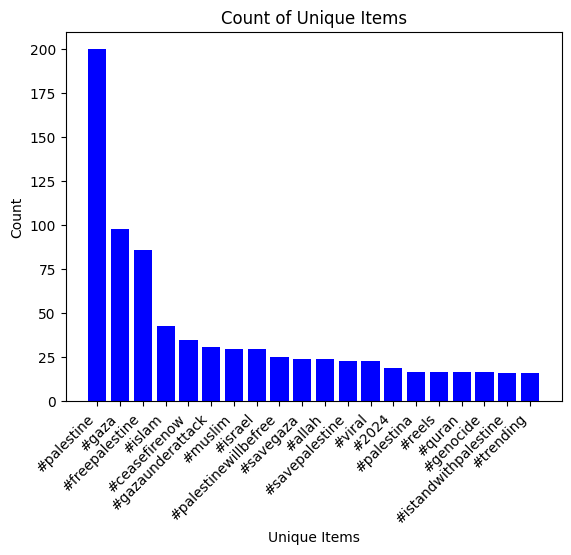

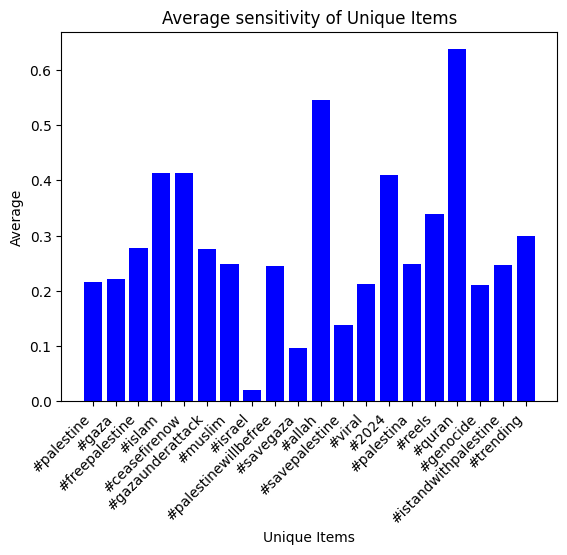

In [186]:
plot_hashtag_occurence(df_posts)

here can be some things seen, we see that the freepalastine hashtag comes at the most often times. The isreal hashtag is on the 4 place. the hashtags are clearly onthe palastine side.

In [53]:
df_posts["language"].value_counts()[:10].plot(kind="pie",title="Top 10 languages in general in data set")


KeyError: 'language'

In [ ]:
# check what languages occur how much items not get any language tag

df_posts.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head()


C:\Users\savas\AppData\Local\Temp\ipykernel_21164\2320503435.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_posts.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head()


,,id
language,language_fullname,
en,English,101880
id,Indonesian,17293
ar,Arabic,9633
tr,Turkish,7217
it,Italian,6963


It is pretty intresting that we get a lot of indonesion language.

In [ ]:
pd.set_option('display.max_colwidth', None)
df_posts[df_posts['language'] == "id"].head(10).loc[:,("caption","language")]

,caption,language
333652,Desember 2023 hampir berakhir🥺 doa ini selalu ada untuk kemenangan 🇵🇸 Semoga peperangan ini cepat berakhir ya Allah Aamiinn... حَسْبُنَا اللَّهُ وَنِعْمَ الْوَكِيلُ #gaza #palestine #freepalestine,id
333634,Aadegan dari pertempuran Hay al-Shujaiya antara Brigade Qsam dan tentara Israel. #gazaunderattack #gaza #freepalestine #savepalestine #gerilya #guerrilla,id
333629,💝 . . . . #🇵🇸 #palestine #gaza #gazaunderfire #gaza_under_attack #surat #surahbakarah #palestine🇵🇸 #🇵🇸فلسطين,id
333624,"Beberapa hari selepas pemilik syarikat hartanah Israel mengumumkan rancangan untuk membina chalet di pantai-pantai Gaza yang musnah, abangnya, yang merupakan seekor askar Zionis, telah mampus di tengan pejuang Palestin di Semenanjung Gaza semalam. #iloveisrael #israeltourism #isupportisrael #israelunderfire #visitisrael #israel #jerusalem #telaviv #bbc #cnn #chanelnewsasia #foxnews #israel_times #ajplus #aljazeera #gaza #palestine #jewlivesmatter #israeldefenceforce #israel_best #jewish #shalom #loveisrael #kolisrael #shabatshalom #usa #kosher #lovejerusalem #israelinstagram #israelunderattack",id
333616,۞﷽۞اَللهُمَّ صَلِّ عَلَى سَيِّدِنَا مُحَمَّدٍ وَعَلَى آلِ سَيِّدِنَا مُحَمَّدٍ۞ ** Teruskan Suarakan Gaza (Palestina) ** Hasbunallah Wa Ni'mal Wakiil.. ** #freepalestine #savepalestine #savegaza #explorepage #explore #gazawar #gaza #savehumanity #alquran #doauntukpalestina #tareem #umatislam #nasihat #syeikhalbuthi #cintaulama #sayyidbahar #alhabibmunziralmusawa #habibjindan #buyayahya #gurusekumpul #cintahabibumar #cintasholawat #cintahabaib #majelisrasulullahsaw #alhabibumarbinhafidz #الحبيب_عمر_بن_حفيظ #الحبيب_منذر_المساوى,id
333614,"Dalam kenyataan akhbar... Pergerakan Hamas: Kami mengucapkan tahniah kepada operasi kepahlawanan yang dilakukan oleh syuhada, Mujahid Ahmed Alyan, anak kepada bandar Al-Mukaber di Baitulmaqdis. Operasi di pusat pemeriksaan Mazmoria adalah tindak balas semula jadi daripada rakyat kami terhadap pembunuhan beramai-ramai Nazi dan jenayah yang dilakukan oleh penjajah, dan kami menyeru rakyat kami untuk menjalankan lebih banyak operasi dan terlibat dengan semua pihak. #iloveisrael #israeltourism #isupportisrael #israelunderfire #visitisrael #israel #jerusalem #telaviv #bbc #cnn #chanelnewsasia #foxnews #israel_times #ajplus #aljazeera #gaza #palestine #jewlivesmatter #israeldefenceforce #israel_best #jewish #shalom #loveisrael #kolisrael #shabatshalom #usa #kosher #lovejerusalem #israelinstagram #israelunderattack",id
333606,۞﷽۞اَللهُمَّ صَلِّ عَلَى سَيِّدِنَا مُحَمَّدٍ وَعَلَى آلِ سَيِّدِنَا مُحَمَّدٍ۞ ** Teruskan Suarakan Gaza (Palestina) ** Hasbunallah Wa Ni'mal Wakiil.. ** #freepalestine #savepalestine #savegaza #explorepage #explore #gazawar #gaza #savehumanity #alquran #doauntukpalestina #tareem #umatislam #nasihat #syeikhalbuthi #cintaulama #sayyidbahar #alhabibmunziralmusawa #habibjindan #buyayahya #gurusekumpul #cintahabibumar #cintasholawat #cintahabaib #majelisrasulullahsaw #alhabibumarbinhafidz #الحبيب_عمر_بن_حفيظ #الحبيب_منذر_المساوى,id
333603,"Seorang bapa membawa dua anak perempuannya, seorang daripadanya syahid dan seorang lagi cedera akibat pengeboman rejim Zionis di Nuseirat , tengah Semenanjung Gaza. #iloveisrael #israeltourism #isupportisrael #israelunderfire #visitisrael #israel #jerusalem #telaviv #bbc #cnn #chanelnewsasia #foxnews #israel_times #ajplus #aljazeera #gaza #palestine #jewlivesmatter #israeldefenceforce #israel_best #jewish #shalom #loveisrael #kolisrael #shabatshalom #usa #kosher #lovejerusalem #israelinstagram #israelunderattack",id
333601,Minara Masjid >> 👑🖤. Pov: An Evening at Minara muhammad_ajmaeen . . . #minaramasjid #muslim #islam #musalman #madina #makkah #haramain#hijab #hijabi #momin #palestine #gaza,id
333594,Hampir sampai pada kemenangan ✊🏻🇵🇸 #istandwithpalestine #palestine #freepalestine #gaza,id


In [ ]:
# also we can look at the occurene of language in longer texts, we see that the first 4 places are the same, also I tried values like 100, 200 or 300. The order of the languages not changes
# for the first places, that posts that contain only hashtags are not affecting the grouping after languages. Since I think there are rare posts with more than 200 characters only with hashtags
longer_df = df_posts[df_posts["caption_length"] > 300]
len(longer_df)

72084

In [ ]:
longer_df.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head(10)

C:\Users\savas\AppData\Local\Temp\ipykernel_21164\2999832352.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  longer_df.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head(10)


,,id
language,language_fullname,
en,English,44445
id,Indonesian,8633
ar,Arabic,3503
tr,Turkish,3318
es,Spanish,2041
et,Estonian,1600
pt,Portuguese,1380
it,Italian,1110
fr,French,956


In [ ]:
# also we can see for longer texts that the language detection workds really good
df_posts[(df_posts["caption_length"] > 300) & (df_posts["language"] != "en")][["caption","language","hashtags"]].head(10)

,caption,language,hashtags
333651,"“Llévate estas galletas contigo al cielo” Este padre palestino fue a comprar galletas para su hijo, y cuando regresó, encontró a su hijo y a su esposa asesinados por misiles israelíes en la casa a la que habían huido en Khan Yunis. #palestina #palestinalibre #freepalestine #gaza #gazaunderattack #gazapalestine #gazagenocide #palestine🇵🇸 #savegaza #genocide #freegaza #palestinewillbefree #savepalestine #israelgenocida #israelterrorist #IsraelInfanticida #israel #sionismo #hasbara #hasbarasionista #hasbaraisrael #apartheidisraeli #ceasefire #ceasefirenow #stopgenocide #stopgenocidenow #altoalfuego #altoalfuegoahora #cesealfuego",es,"[#palestina, #palestinalibre, #freepalestine, #gaza, #gazaunderattack, #gazapalestine, #gazagenocide, #palestine, #savegaza, #genocide, #freegaza, #palestinewillbefree, #savepalestine, #israelgenocida, #israelterrorist, #israelinfanticida, #israel, #sionismo, #hasbara, #hasbarasionista, #hasbaraisrael, #apartheidisraeli, #ceasefire, #ceasefirenow, #stopgenocide, #stopgenocidenow, #altoalfuego, #altoalfuegoahora, #cesealfuego]"
333650,"“Her eylem yeniden diriltir bizi!” diyerek , şehitlerimize rahmet, Filistin’e destek için toplanıyoruz. 🗓️ 1 Ocak Pazartesi 08.30 - Galata Köprüsü #feraset #ferasetderneği #dernek #yardım #destek #ilgi #şefkat #ihtiyaç #aile #sadaka #zekat #yardımeli #kuranıkerim #allah #filistin #filistineözgürlük #gazze #gazzedekatliamvar #palestine #israel #Gaza #şehit #şehidinvartürkiye #dünyadursundünyaduysun",tr,"[#feraset, #ferasetderneği, #dernek, #yardım, #destek, #ilgi, #şefkat, #ihtiyaç, #aile, #sadaka, #zekat, #yardımeli, #kuranıkerim, #allah, #filistin, #filistineözgürlük, #gazze, #gazzedekatliamvar, #palestine, #israel, #gaza, #şehit, #şehidinvartürkiye, #dünyadursundünyaduysun]"
333643,Israel es un mercenario genocida. #palestina #palestinalibre #freepalestine #gaza #gazaunderattack #gazapalestine #gazagenocide #palestine🇵🇸 #savegaza #genocide #freegaza #palestinewillbefree #savepalestine #israelgenocida #israelterrorist #IsraelInfanticida #israel #sionismo #hasbara #hasbarasionista #hasbaraisrael #apartheidisraeli #ceasefire #ceasefirenow #stopgenocide #stopgenocidenow #altoalfuego #altoalfuegoahora #cesealfuego,es,"[#palestina, #palestinalibre, #freepalestine, #gaza, #gazaunderattack, #gazapalestine, #gazagenocide, #palestine, #savegaza, #genocide, #freegaza, #palestinewillbefree, #savepalestine, #israelgenocida, #israelterrorist, #israelinfanticida, #israel, #sionismo, #hasbara, #hasbarasionista, #hasbaraisrael, #apartheidisraeli, #ceasefire, #ceasefirenow, #stopgenocide, #stopgenocidenow, #altoalfuego, #altoalfuegoahora, #cesealfuego]"
333641,En los bombardeos Israel arrasa con todo; eso incluye animales. #palestina #palestinalibre #freepalestine #gaza #gazaunderattack #gazapalestine #gazagenocide #palestine🇵🇸 #savegaza #genocide #freegaza #palestinewillbefree #savepalestine #israelgenocida #israelterrorist #IsraelInfanticida #israel #sionismo #hasbara #hasbarasionista #hasbaraisrael #apartheidisraeli #ceasefire #ceasefirenow #stopgenocide #stopgenocidenow #altoalfuego #altoalfuegoahora #cesealfuego,es,"[#palestina, #palestinalibre, #freepalestine, #gaza, #gazaunderattack, #gazapalestine, #gazagenocide, #palestine, #savegaza, #genocide, #freegaza, #palestinewillbefree, #savepalestine, #israelgenocida, #israelterrorist, #israelinfanticida, #israel, #sionismo, #hasbara, #hasbarasionista, #hasbaraisrael, #apartheidisraeli, #ceasefire, #ceasefirenow, #stopgenocide, #stopgenocidenow, #altoalfuego, #altoalfuegoahora, #cesealfuego]"
333631,"1 milió d'euros s'ha gastat l'ajuntament sabadell_cat en llums de nadal, el_llaminer_sabadell i ximpleries varies... és també responsabilitat popular sortir al carrer i manifestar-se en contra de la superficialitat estúpida d'aquestes festes i recollir la solidaritat i l'empatia cap a les persones més desfavorides i les causes socials més importants 1 millón de euros se ha gastado el ayuntamiento sabadel

In [ ]:
df_posts["sensitivity"].describe()

<Axes: >

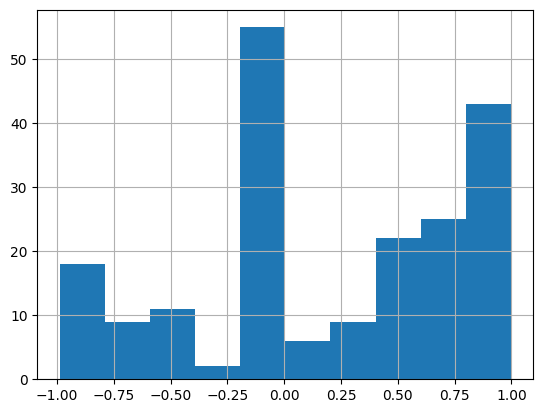

In [176]:
# looking at the sensitivity of the data in general.
df_posts["sensitivity"].hist()


In [177]:
# plot average for top 20 hashtags
df_posts[df_posts.apply(lambda x: "#palestine" in  x["hashtags"],axis=1)]["sensitivity"].mean()


0.2158605

### 2.1 Considering the war hashtag how important is the palestine israel war

In [ ]:
# let's look how important the palestine and isreal war is
messages_that_contain_war_hashtag = df_posts[df_posts.apply(lambda x: "#war" in  x["hashtags"],axis=1)]


messages_that_contain_war_hashtag[["caption","hashtags","language","language_fullname"]].head()




,caption,hashtags,language,language_fullname
333657,#palestine #gaza #israel #police #streetphotography #war #documentaryphotograhy #warphotography,"[#palestine, #gaza, #israel, #police, #streetphotography, #war, #documentaryphotograhy, #warphotography]",en,English
333517,🚨SHARE THE TRUTH ABOUT GAZA🚨 This conflict has always been bigger than what they state it is. Gaza has 500 billion dollars worth of oil under it. Along with geographic location it's needed to build the BEN GURIAN CANAL. This is a CANAL project Israel has been pushing to control trade going into Europe. THEY STAND TO MAKE BILLIONS BY TAKING GAZA!! 🚨SHARE THIS TRUTH 🚨 FREE PALESTINE 🇵🇸 🚨🚨🚨 FOLLOW ME AND MY TELEGRAM FOR NEWS UPDATES AND UNCENSORED FOOTAGE OF THE RESISTANCE!! 🚨🚨🚨 #news #breaking #updates #Palestine #Israel #world #conflict #history #movement #occupation #military #war #Gaza,"[#news, #breaking, #updates, #palestine, #israel, #world, #conflict, #history, #movement, #occupation, #military, #war, #gaza]",en,English
333495,"Ein kleines Kind wurde aus den Trümmern seines Hauses gerettet, das durch einen israelischen Luftangriff in Khan Younis bombardiert wurde. 29.12.23 #gaza #israel #war","[#gaza, #israel, #war]",de,German
333487,İsrail Dışişleri Bakanı Eli Cohen: Erdoğan Türkiye'nin cumhurbaşkanı olarak kaldığı sürece İsrail büyükelçisinin Ankara'ya dönmesine yer yok. #instanews #instaflash #instafollow #haber #sondakika #gündem #olay #flashhaber #turkey #ajans #global #palestine #filistin #gazze #gaza #gazaunderattack #israel #war #warzone #israel #israil,"[#instanews, #instaflash, #instafollow, #haber, #sondakika, #gündem, #olay, #flashhaber, #turkey, #ajans, #global, #palestine, #filistin, #gazze, #gaza, #gazaunderattack, #israel, #war, #warzone, #israil]",tr,Turkish
333475,Watermelon 🍉 It’s more than a fruit✌🏻😉 Drawing by me👩🏻‍💻🎨 #war #drawing #graphicdesign #graphicdesigner #adobeillustrator #adobephotoshop #iraq #القدس #baghdad #القدس_عربية #baghdad_live ‎#الجيش_العراقي #gaza#palestine ‎ #جهاز_مكافحة_الارهاب #غزة #الرد_السريع #العراق #قوات_الرد_السريع#قوات_الرد_السريع_العراقية ‎الرد_السريع_حماة_الوطن##فلسطين_عربية #art #photography #photojurnalism#photographer,"[#war, #drawing, #graphicdesign, #graphicdesigner, #adobeillustrator, #adobephotoshop, #iraq, #القدس, #baghdad, #القدس_عربية, #baghdad_live, #الجيش_العراقي, #gaza, #palestine, #جهاز_مكافحة_الارهاب, #غزة, #الرد_السريع, #العراق, #قوات_الرد_السريع, #قوات_الرد_السريع_العراقية, #فلسطين_عربية, #art, #photography, #photojurnalism, #photographer]",so,Somali


In [ ]:
print(f"Amount of posts that contain #war: {len(messages_that_contain_war_hashtag)}")

Amount of posts that contain #war: 11068


Top hashtags:
[('#war', 11068), ('#gaza', 2888), ('#palestine', 2849), ('#israel', 2428), ('#freepalestine', 1489), ('#ukraine', 1298), ('#peace', 1188), ('#genocide', 1018), ('#news', 955), ('#usa', 895), ('#history', 865), ('#instagram', 847), ('#love', 836), ('#islam', 816), ('#russia', 792), ('#viral', 770), ('#reels', 739), ('#fyp', 732), ('#gazaunderattack', 670), ('#military', 607)]


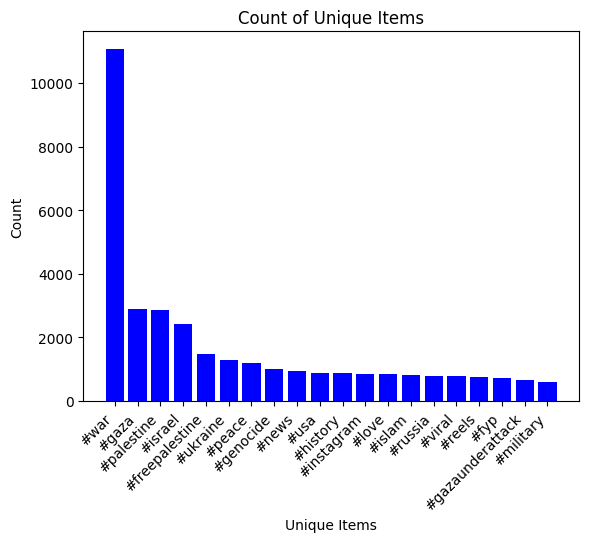

In [ ]:
plot_hashtag_occurence(messages_that_contain_war_hashtag)

Here we can see that for the war hashtag the #gaza is the most occuring in the posts, showing also the international importance. For example the russian ukraine war is on the 6 st. place. Also it less than half of occurence then the  gaza hashtag.

In [ ]:
messages_that_contain_war_hashtag[["language",'language_fullname']].value_counts()[:10]

language  language_fullname
en        English              7935
uk        Ukrainian             331
id        Indonesian            250
tr        Turkish               240
ar        Arabic                204
et        Estonian              189
it        Italian               168
de        German                149
af        Afrikaans             149
es        Spanish               148
Name: count, dtype: int64

In [ ]:
# the first 5 places are the same the order is a litle bit changed but a see a difference after the first 5 places
messages_that_contain_war_hashtag_longer = messages_that_contain_war_hashtag[messages_that_contain_war_hashtag["caption_length"] > 200]
messages_that_contain_war_hashtag_longer[["language",'language_fullname']].value_counts()[:10]

language  language_fullname
en        English              5443
uk        Ukrainian             257
tr        Turkish               178
ar        Arabic                165
id        Indonesian            152
it        Italian               132
et        Estonian              130
pt        Portuguese            112
fr        French                110
es        Spanish               103
Name: count, dtype: int64

### 2.2 What are the opinions for that come with the palestine hashtag

Top hashtags:
[('#palestine', 73109), ('#gaza', 42366), ('#freepalestine', 35348), ('#israel', 16236), ('#gazaunderattack', 13432), ('#islam', 12196), ('#savepalestine', 9387), ('#muslim', 9295), ('#ceasefirenow', 8809), ('#palestinewillbefree', 8700), ('#genocide', 7564), ('#savegaza', 7283), ('#palestina', 7164), ('#فلسطين', 6614), ('#allah', 6332), ('#freegaza', 5411), ('#reels', 5411), ('#instagram', 5286), ('#fyp', 5170), ('#istandwithpalestine', 5149)]


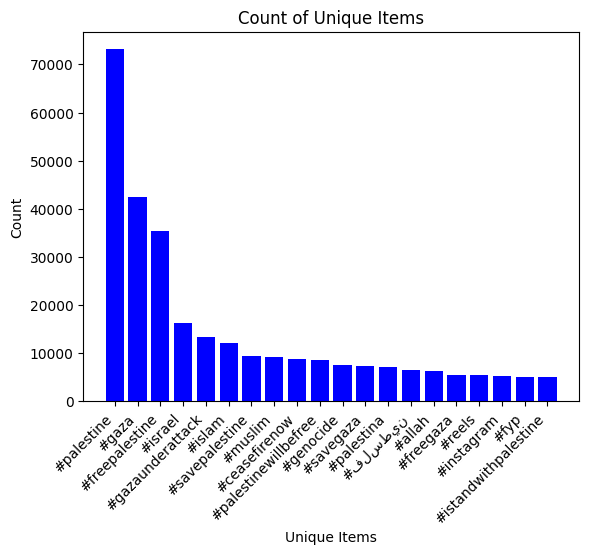

In [ ]:
posts_with_palastine = df_posts[df_posts.apply(lambda x: "#palestine" in  x["hashtags"],axis=1)]
plot_hashtag_occurence (posts_with_palastine)

We can see here the opions for palestine. The most common hashtag here is also freepalestine

In [ ]:
# let's look at if there is any language bias, it is basically the same as looking on all hashtags
posts_with_palastine.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head()

C:\Users\savas\AppData\Local\Temp\ipykernel_21164\2609364898.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  posts_with_palastine.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head()


,,id
language,language_fullname,
en,English,42651
id,Indonesian,6106
ar,Arabic,4607
it,Italian,4179
tr,Turkish,3207


In [ ]:
posts_with_palastine_longer = posts_with_palastine[posts_with_palastine["caption_length"] > 200]
posts_with_palastine_longer[["language",'language_fullname']].value_counts()[:10]

language  language_fullname
en        English              31007
id        Indonesian            4854
ar        Arabic                3024
tr        Turkish               2323
et        Estonian              1299
it        Italian               1156
fr        French                 773
es        Spanish                574
ru        Russian                435
ca        Catalan                418
Name: count, dtype: int64

### 2.3 What are opionions which come with the Isreal hashtag

Top hashtags:
[('#israel', 37802), ('#gaza', 16682), ('#palestine', 16236), ('#freepalestine', 10036), ('#gazaunderattack', 4726), ('#islam', 4146), ('#palestina', 3970), ('#usa', 3969), ('#jerusalem', 3957), ('#muslim', 3651), ('#savepalestine', 3022), ('#genocide', 2884), ('#ceasefirenow', 2857), ('#savegaza', 2777), ('#westbank', 2771), ('#palestinewillbefree', 2645), ('#love', 2544), ('#palestinian', 2509), ('#war', 2428), ('#hamas', 2151)]


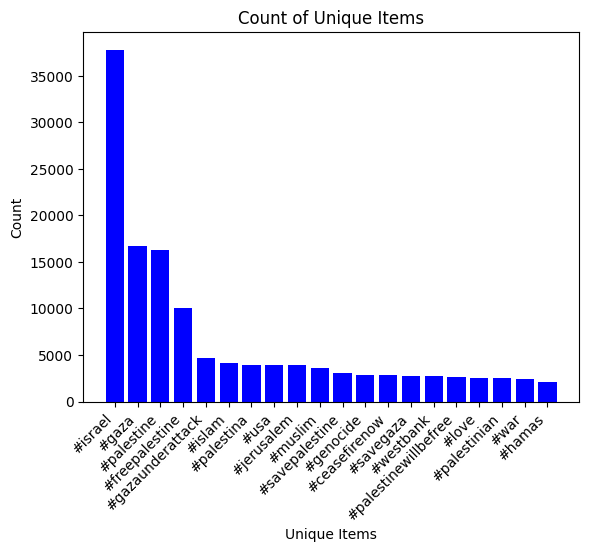

In [ ]:
posts_isreal_df = df_posts[df_posts.apply(lambda x: "#israel" in  x["hashtags"],axis=1)]
plot_hashtag_occurence(posts_isreal_df)

Especially here can be seen, that the palestine and gaza hashtag occurs at the most, displaying the importance also of the war when post somehting on instagram related to isreal. For example we can not see any messages for free time activities or for fashion. We see that the hashtags in connection to israel favour more palastine for example #gazaunderattack or #freepalastine

In [ ]:
posts_isreal_df.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head(10)

C:\Users\savas\AppData\Local\Temp\ipykernel_21164\250231539.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  posts_isreal_df.loc[:,('id','language','language_fullname')].groupby(['language','language_fullname']).count().sort_values("id",ascending=False).head(10)


,,id
language,language_fullname,
en,English,23864
es,Spanish,1811
id,Indonesian,1727
et,Estonian,1381
pt,Portuguese,1374
tr,Turkish,1199
it,Italian,1018
ar,Arabic,811
fr,French,606


In [ ]:
posts_isreal_df_longer = posts_isreal_df[posts_isreal_df["caption_length"] > 200]
posts_isreal_df_longer[["language",'language_fullname']].value_counts()[:10]

language  language_fullname
en        English              18075
id        Indonesian            1434
es        Spanish               1387
pt        Portuguese            1144
tr        Turkish               1021
et        Estonian               726
ar        Arabic                 575
ru        Russian                436
it        Italian                427
fr        French                 423
Name: count, dtype: int64

In [ ]:
posts_isreal_df.sort_values('like_count',ascending=False)[["caption","like_count","timestamp","permalink","language"]].head(5)

,caption,like_count,timestamp,permalink,language
146292,"The Government Media Office in #Gaza has accused #Israel of stealing organs from 80 #Palestinian bodies returned earlier in the day at the Karam Abu Salem (Kerem Shalom) border crossing.⁠ .⁠ “The media office denounces in the strongest terms the #Israeli occupation army’s disdain for the dignity of the bodies of our 80 martyrs that Israel had stolen during its genocidal war because it delivered them mutilated,” a statement said.⁠ .⁠ “After examining the bodies, it is clear that the features of those killed had changed greatly in a clear indication that the Israeli occupation had stolen vital organs from them,” the statement went on to say.⁠ .⁠ The media office said this is not the first time Israel has “mutilated” Palestinian bodies, and it called for an independent international investigation into the taking of Palestinian bodies and theft of their organs.⁠ .⁠ “Israel has previously exhumed graves in Jabalia and stole some of the bodies in addition to the fact that it still has dozens of bodies from the Gaza Strip in its possession,” the office said.⁠ .⁠ 🔗Tap the link in bio for 🔴 LIVE updates.⁠ .⁠ #Israel_Gaza_War⁠ #Palestine⁠ .⁠ 📸 Fadi Shana,reuters",231371.0,2023-12-27 10:24:30+00:00,https://www.instagram.com/p/C1Wl9RKsofG/,en
128961,"A blast occurred close to the Israel embassy in New Delhi on Monday, following which security has been beefed up in the area. The embassy has confirmed the incident, and no casualties or injuries have been reported. Sources said two suspects were caught on CCTV near the blast site and efforts are underway to track their movements and apprehend them. Delhi Police is also analysing footage from nearby cameras to reconstruct the suspects' route to the embassy and uncover their potential accomplices. A typed letter addressed to the Ambassador of the Israeli embassy, wrapped in an Israeli flag, was found near the blast site, sources cited by India Today said. The letter, written in English, talks about Israel's actions in Gaza and mentions 'revenge', sources said, adding that a group identifying itself as ""Sir Allah Resistance"" claimed responsibility for the blast. It is possible that the explosion near the Israeli embassy in New Delhi is an attack, Tel Aviv has said, putting out an advisory for Israelis living in India and particularly in New Delhi. The advisory asks Israelis to avoid visiting crowded places such as malls and markets, particularly areas frequented by people from the community. It also asks them to stay alert and ""avoid externalizing Israeli symbols"". ""Avoid participating in events with many participants that are not secure. Avoid posting trip details on social networks and posting photos and visit details before the trip and in real time,"" the advisory says. Police and other officials rushed near the Embassy of Israel after Delhi police received a call about a blast near the embassy, in New Delhi district, Tuesday evening. According to Delhi Fire Services officials, the call was received at 5.47 pm and was transferred from the PCR (police control room) of the Delhi Police. Following an initial probe, the Delhi Police said no explosive has been found so far but search operation is still on. . . . #TheTatva #TatvaNews #India #Israel #Delhi #Blast #Bomb #Attack #Gaza #Palestine #Police #Embassy #Chanakyapuri #Force #Investigate",101385.0,2023-12-27 04:45:10+00:00,https://www.instagram.com/p/C1V_JHvhmJ1/,en
55035,"Dan Halutz has said that #Israel has lost the war against Hamas and that victory can only be achieved when #Netanyahu steps down.⁠ .⁠ His comments were recorded from a conversation he had with antigovernment protestors in #Haifa and aired on #Israeli Channel 14. Many members of the audience applauded his statement.⁠ .⁠ 🔗Tap the link in bio for 🔴 LIVE updates.⁠ .⁠ #Israel_Gaza_War #Palestine #Gaza⁠ .⁠ 📸 Mohammed Salem, reuters",81294.0,2023-12-26 12:11:01+00:00,https://www.instagram.com/p/C1UNW8RM9c2/,en
142557,"

We can see here also that this messages are also clearly negtive speaking about israel, for example to find also is the post from president from turkey